# Basic analysis for Sephora foundation reviews

- Overview
    - [About the dataset](#about)
    - [Missingness](#missing)
- Dataset characteristics
    - [Overview](#overview)
    - [Location overview](#location_overview)
    - [Brand overview](#brand_overview)
    - [Age overview](#age_overview)
    - [Membership status](#membership_status)
- [Foundation characteristics](#foundation_characteristics)
- [Incentivized reviews](#incentivized)



- [Conclusions](#conclusions)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [3]:
reviews = pd.read_csv("./data/sephora_reviews_final.csv")

## Overview

<a id='about'></a>

### About the dataset:

In total, our dataset consists of 275,950 foundation reviews with 28 different columns. These columns include brand, name, product id, coverage, foundation, finish, formulation, normal skin, oily skin, combo skin, dry skin, SPF, username, rating, recommend, skin type, eye color, skin tone, skin concerns, age, beauty insider, price, first submission date, last submission date, location, incentivized review, review text, brand image url, and product image url. For our purposes, we will not need to analyze every columns, but we do have comprehensive information on user preferences and profiles (i.e. age, skin type, location, rating, recommendation) , as well as product information (coverage, finish, price).

In [4]:
reviews.sample(3)

,brand,name,product_id,coverage,finish,formulation,normal_skin,oily_skin,combo_skin,dry_skin,SPF,user_name,rating,recommended,skin_type,eye_color,skin_tone,skin_concerns,age,beauty_insider,price,first_submission_date,last_submission_date,location,incentivized_review,review_text,brand_image_url,product_image_url
240764,Anastasia Beverly Hills,Stick Foundation,P410504,NaN,NaN,NaN,False,False,False,False,False,neinei,5,NaN,NaN,hazel,fair,NaN,25to34,yes,25.0,2017-07-31 15:53:33,2017-07-31 16:00:04,"New York, NY",False,"This stick might be the perfect example of ""on...",/contentimages/brands/anastasia/anastasia_logo...,https://www.sephora.com/productimages/sku/s185...
177553,CLINIQUE,Beyond Perfecting Foundation + Concealer,P393325,NaN,NaN,NaN,True,True,True,True,False,sophem,5,NaN,combination,brown,medium,NaN,18to24,yes,29.0,2015-05-20 21:54:39,2015-05-20 22:00:05,"San Francisco, CA",False,This foundation is fantastic. I am always on t...,/contentimages/brands/clinique/101818/2018-10-...,https://www.sephora.com/productimages/sku/s191...
270779,Dior,Hydra Life BB Creme Broad Spectrum SPF 30,P308100,NaN,NaN,NaN,False,False,False,False,True,hilly1635,4,NaN,NaN,NaN,NaN,NaN,25to34,yes,60.0,2012-05-25 02:20:01,2012-05-25 02:30:08,"Houston, TX",NaN,I haven't used this consistently yet but every...,/contentimages/brands/dior/1073_logo_279.png,https://www.sephora.com/productimages/sku/s149...


In [5]:
reviews.shape

(275950, 28)

In [6]:
#reviews.info()

<a id='missing'></a>

### Missingness

We should also try and get an idea of our data--what do we have and what are we missing?

We can see that we have most of the important information: brand, name/product id, rating, price, and review text, as well as some other secondary information.

Columns with missing data:
- **coverage**: 31.826780%
- **finish**: 32.198587%
- **formulation**: 44.085160%
- **user_name**: 1.065410%
- **recommended**: 70.390650%
- **skin_type**: 51.308933%
- **eye_color**: 35.678203%
- **skin_tone**: 33.739083%
- **skin_concerns**: 74.319623%
- **age**: 56.678384%
- **beauty_insider**: 59.779308%
- **location**: 58.768255%
- **incentivized_review**: 71.218337%

Columns with missing values have variable amounts of missingness, so we need to remember to take any analysis with these columns with a grain of salt. That being said, I think there is still valuable information that give us insight on how users are rate foundations.

In [7]:
reviews.columns[reviews.isna().sum(axis = 0) == 0]

Index(['brand', 'name', 'product_id', 'normal_skin', 'oily_skin', 'combo_skin',
       'dry_skin', 'SPF', 'rating', 'price', 'first_submission_date',
       'last_submission_date', 'review_text', 'brand_image_url',
       'product_image_url'],
      dtype='object')

In [8]:
reviews.isna().sum(axis = 0)[reviews.isna().sum(axis = 0) > 0]/len(reviews)*100

coverage               31.826780
finish                 32.198587
formulation            44.085160
user_name               1.065410
recommended            70.390650
skin_type              51.308933
eye_color              35.678203
skin_tone              33.739083
skin_concerns          74.319623
age                    56.678384
beauty_insider         59.779308
location               58.768255
incentivized_review    71.218337
dtype: float64

<a id='overview'></a>

### Overview

On average, users gave foundations a rating of 4.12 with a standard deviation of 1.26. The 25th percentile tells us that most ratings are 4+ stars, indicating that we have a skewed distribution.

We also have 63 brands, 217 foundations, 3 types of coverage, 3 types of finishes, 6 types of formulations, 2 types of recommendations (T/F), 4 skin types, 5 eye colors, 9 skin tones, 15 skin concerns, 6 age groups, 4 beauty insider statuses, 20502 locations, 2 types of incentivized reviews (T/F), and 263406 unique reviews.

In [9]:
reviews[["rating"]].describe()

,rating
count,275950.000000
mean,4.123794
std,1.255406
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [21]:
avg_rating = reviews["rating"].mean()

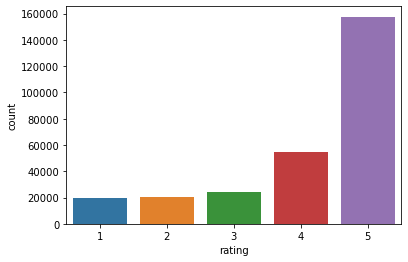

In [11]:
sns.countplot("rating", data = reviews)

In [10]:
reviews.describe(include = ["O"])

,brand,name,product_id,coverage,finish,formulation,user_name,recommended,skin_type,eye_color,skin_tone,skin_concerns,age,beauty_insider,first_submission_date,last_submission_date,location,incentivized_review,review_text,brand_image_url,product_image_url
count,275950,275950,275950,188124,187098,154297,273010,81707,134363,177496,182847,70865,119546,110989,275950,275950,113779,79423,275950,275950,275950
unique,63,217,217,3,3,6,206386,2,4,5,9,15,6,4,263462,145820,20502,2,263406,63,2995
top,bareMinerals,Original Foundation Broad Spectrum SPF 15,P61003,Medium,Matte,Liquid,ashley26,True,combination,brown,light,acne,25to34,yes,2010-03-25 02:30:46,2017-12-21 19:16:19,"New York, NY",False,What a wonderful product this powder foundatio...,/contentimages/brands/bareescentuals/082212_ba...,https://www.sephora.com/productimages/sku/s192...
freq,36814,19292,19292,96283,85560,105485,63,64632,70739,91257,55695,37509,42920,80476,5,433,3065,75319,42,36814,19025


<a id = "location_overview"></a>

### Location overview

We can take a further look at our location data. While this is not a perfect fix, we can clean up the "location" column to see where our reviewers/purchasers are coming from. The top 10 cities/locations are New York, LA, Chicago, San Francisco, Boston, Houston, Seattle, San Diego, Toronto, and Washington DC. We can see that there isn't a huge difference in rating across the top 10 locations.

In [12]:
reviews["location"] = reviews["location"].str.lower().str.replace('[^\w\s]','').str.strip()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

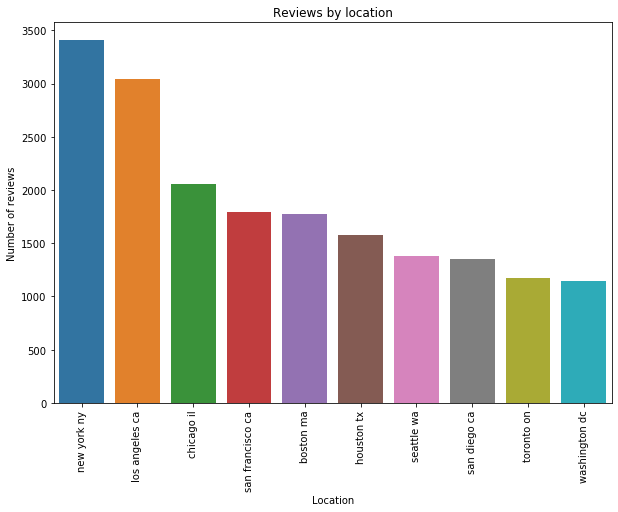

In [14]:
plt.figure(figsize = (10,7))
sns.barplot(reviews["location"].value_counts()[:10].index, reviews["location"].value_counts()[:10])
plt.title("Reviews by location")
plt.xlabel("Location")
plt.ylabel("Number of reviews")
plt.xticks(rotation = 90)

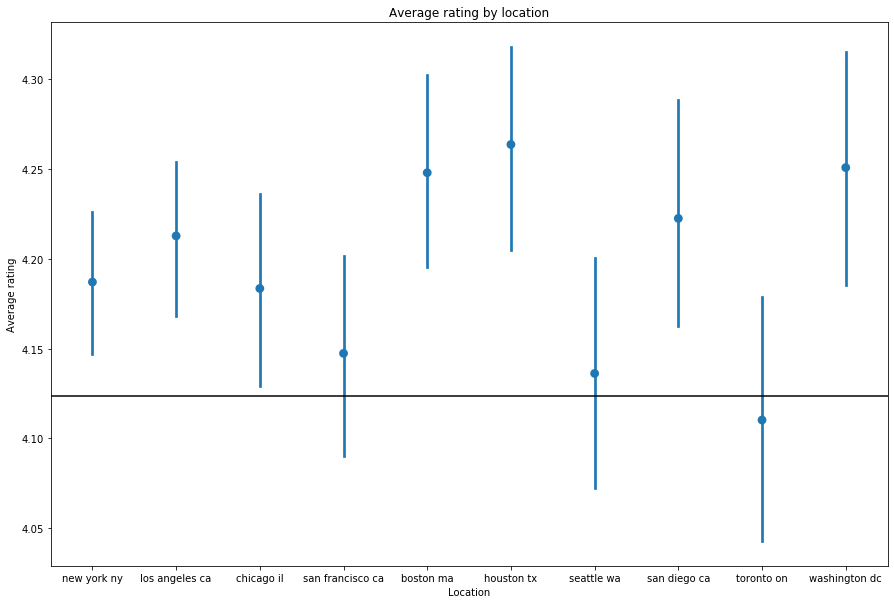

In [26]:
plt.figure(figsize = (15,10))
sns.pointplot(x = "location", y = "rating", data = reviews, estimator = np.mean, order = reviews["location"].value_counts()[:10].index, join = False)
plt.title("Average rating by location")
plt.xlabel("Location")
plt.ylabel("Average rating")
plt.axhline(y=avg_rating, color='black', linestyle='-')

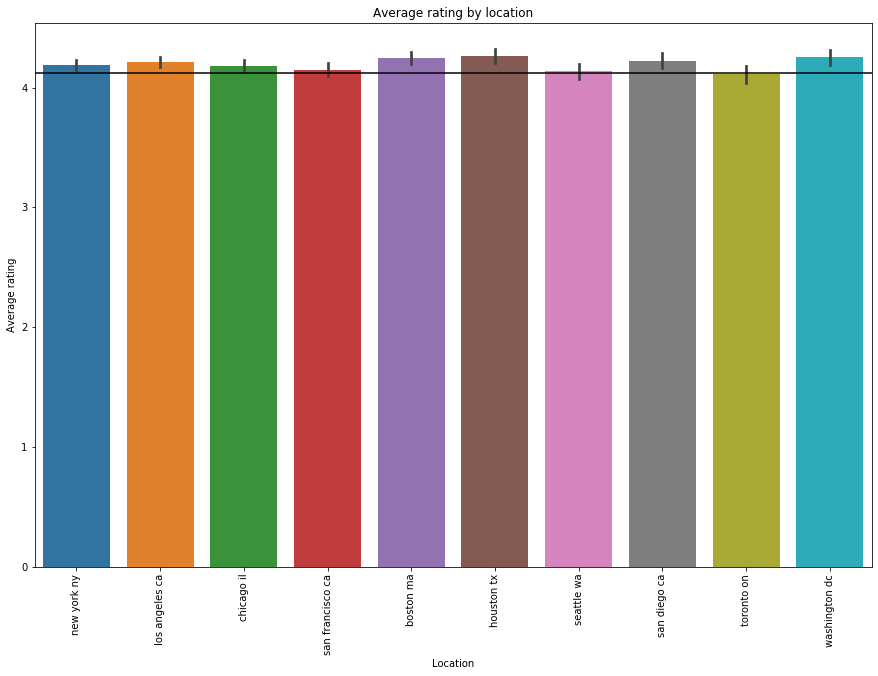

In [25]:
plt.figure(figsize = (15,10))
sns.barplot(x = "location", y = "rating", data = reviews, estimator = np.mean, order = reviews["location"].value_counts()[:10].index)
plt.title("Average rating by location")
plt.xlabel("Location")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)
plt.axhline(y=avg_rating, color='black', linestyle='-')

<a id='brand_overview'></a>

### Brand overview

Sephora houses 217 foundations coming from 63 brands -- 14 for you Clinique, you go Clinique!

In [27]:
reviews[["brand", "name"]].drop_duplicates()[["brand"]].describe()

,brand
count,217
unique,63
top,CLINIQUE
freq,14


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 8 Text xticklabel objects>)

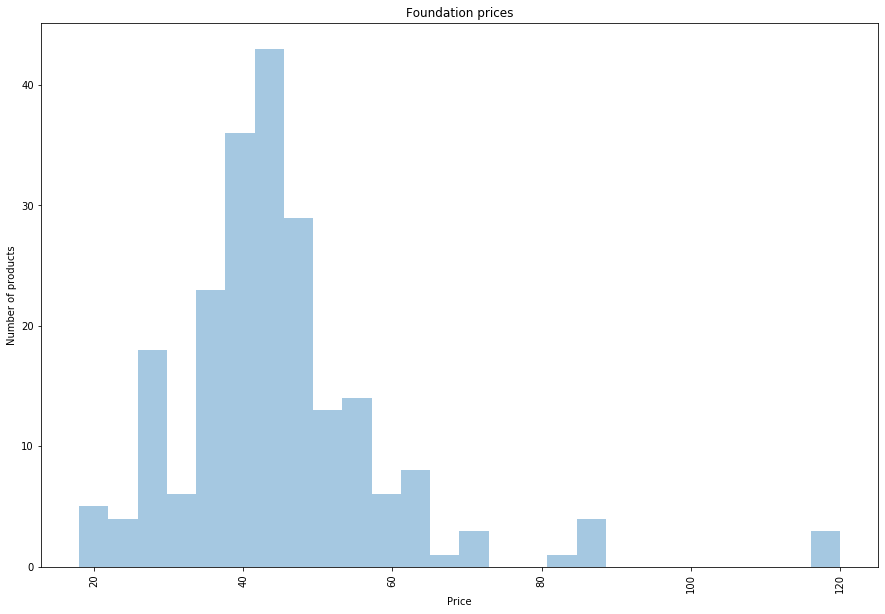

In [33]:
plt.figure(figsize = (15, 10))
sns.distplot(reviews[["brand", "name", "price"]].drop_duplicates()["price"], kde = False)
plt.title("Foundation prices")
plt.xlabel("Price")
plt.ylabel("Number of products")
plt.xticks(rotation = 90)

The average foundation price is \\$44.71, the cheapest being \\$18 and the priciest being \\$120, with a standard deviation of \\$15.02. Again, the foundation prices don't surprise me much since these are pretty consistent with what we would find at Sephora, which houses mainly mid-range to high-end brands. Because we can see that La Mer and Giorgio Armani have some VERY expensive foundations, we should consider the median price since it is robust to extreme values. The median foundation price is $42, and we can see that most of our brands and individual foundations are close to the median price.

In [29]:
reviews[["brand", "name", "price"]].drop_duplicates().describe()

,price
count,217.000000
mean,44.714286
std,15.016547
min,18.000000
25%,37.000000
50%,42.000000
75%,49.000000
max,120.000000


In [30]:
reviews[["brand", "name", "price"]].drop_duplicates().median()

price    42.0
dtype: float64

In [32]:
avg_price = reviews[["brand", "name", "price"]].drop_duplicates()["price"].mean()

In [34]:
median_price = reviews[["brand", "name", "price"]].drop_duplicates()["price"].median()

It does not surprise me that La Mer has a \\$120 foundation. It does surprise me that Giorgio Armani does, but I guess it's also a high-end brand. Sephora's in-house brand is the cheapest, which is unsurprising. One thing that this dataset failed to collect is the product size (i.e. fl oz.). Most foundations are 1 fl. oz., but there is some variability that could make a foundation more (or less expensive) than expected.

In [28]:
reviews[["brand", "name", "price"]].drop_duplicates().sort_values(by="price", ascending = False)

,brand,name,price
270849,Giorgio Armani Beauty,Crema Nuda,120.0
206074,La Mer,The Soft Fluid Long Wear Foundation SPF 20,120.0
206272,La Mer,The Luminous Lifting Cushion Foundation SPF 20...,120.0
192642,TOM FORD,Traceless Foundation Stick,87.0
258420,TOM FORD,Traceless Perfecting Foundation Broad Spectrum...,87.0
265980,TOM FORD,Traceless Foundation Broad Spectrum SPF 15,87.0
244734,TOM FORD,Waterproof Foundation & Concealer,87.0
222585,Dior,Capture Dreamskin Fresh & Perfect Cushion Broa...,82.0
256067,Koh Gen Do,Aqua Foundation,70.0
267347,AMOREPACIFIC,MOISTURE BOUND Tinted Treatment Moisturizer SP...,70.0


In [36]:
# plt.figure(figsize = (15,10))
# sns.pointplot(x = "brand", y = "price", data = reviews, estimator = np.median, order = reviews.groupby("brand").agg({"price": "median"}).reset_index().sort_values(by = "price", ascending = False)["brand"], join = False, ci = None)
# plt.title("Median price by brand")
# plt.xlabel("Brand")
# plt.ylabel("Median price")
# plt.xticks(rotation = 90)
# plt.axhline(y=median_price, color='black', linestyle='-')

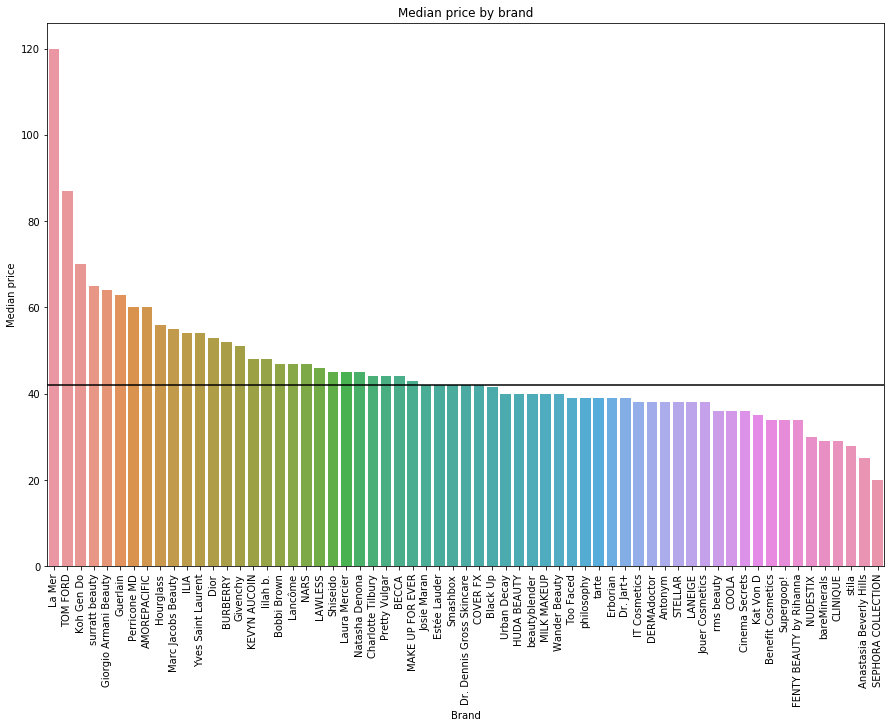

In [124]:
plt.figure(figsize = (15,10))
sns.barplot(x = reviews.groupby(["brand"]).agg({"price": "median"}).sort_values(by = "price", ascending = False).index.to_series(), y = reviews.groupby(["brand"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"], ci = None)
plt.title("Median price by brand")
plt.xlabel("Brand")
plt.ylabel("Median price")
plt.xticks(rotation = 90)
plt.axhline(y=median_price, color='black', linestyle='-')

33 brands sell foundations that are above or at the median price.

In [39]:
print(len(reviews.groupby(["brand"]).agg({"price": "median"})[reviews.groupby(["brand"]).agg({"price": "median"})["price"] >= median_price]))
reviews.groupby(["brand"]).agg({"price": "median"})[reviews.groupby(["brand"]).agg({"price": "median"})["price"] >= median_price].index.to_list()

33


['AMOREPACIFIC',
 'BECCA',
 'BURBERRY',
 'Bobbi Brown',
 'COVER FX',
 'Charlotte Tilbury',
 'Dior',
 'Dr. Dennis Gross Skincare',
 'Estée Lauder',
 'Giorgio Armani Beauty',
 'Givenchy',
 'Guerlain',
 'Hourglass',
 'ILIA',
 'Josie Maran',
 'KEVYN AUCOIN',
 'Koh Gen Do',
 'LAWLESS',
 'La Mer',
 'Lancôme',
 'Laura Mercier',
 'MAKE UP FOR EVER',
 'Marc Jacobs Beauty',
 'NARS',
 'Natasha Denona',
 'Perricone MD',
 'Pretty Vulgar',
 'Shiseido',
 'Smashbox',
 'TOM FORD',
 'Yves Saint Laurent',
 'lilah b.',
 'surratt beauty']

There are 30 brands with below-median prices.

In [43]:
print(len(reviews.groupby(["brand"]).agg({"price": "median"})[reviews.groupby(["brand"]).agg({"price": "median"})["price"] < median_price]))
reviews.groupby(["brand"]).agg({"price": "median"})[reviews.groupby(["brand"]).agg({"price": "median"})["price"] < median_price].index.to_list()

30


['Anastasia Beverly Hills',
 'Antonym',
 'Benefit Cosmetics',
 'Black Up',
 'CLINIQUE',
 'COOLA',
 'Cinema Secrets',
 'DERMAdoctor',
 'Dr. Jart+',
 'Erborian',
 'FENTY BEAUTY by Rihanna',
 'HUDA BEAUTY',
 'IT Cosmetics',
 'Jouer Cosmetics',
 'Kat Von D',
 'LANEIGE',
 'MILK MAKEUP',
 'NUDESTIX',
 'SEPHORA COLLECTION',
 'STELLAR',
 'Supergoop!',
 'Too Faced',
 'Urban Decay',
 'Wander Beauty',
 'bareMinerals',
 'beautyblender',
 'philosophy',
 'rms beauty',
 'stila',
 'tarte']

We can also look at the price of individual products in comparison to the median foundation price. This plot isn't the easiest to read, but we can see that most foundations stay pretty close. 108 of these are above median price, 92 are below median price, and 18 are exactly median price.

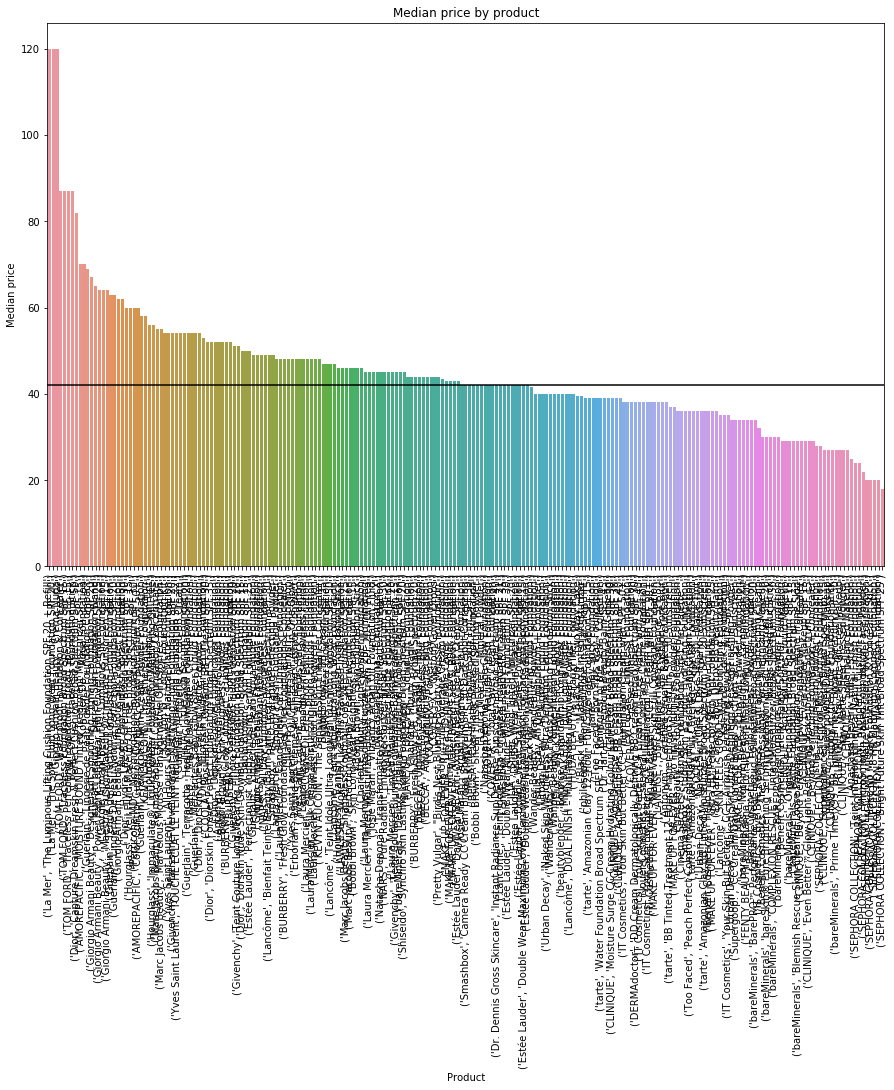

In [44]:
plt.figure(figsize = (15,10))
sns.barplot(x = reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False).index.to_series(), y = reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"], ci = None)
plt.title("Median price by product")
plt.xlabel("Product")
plt.ylabel("Median price")
plt.xticks(rotation = 90)
plt.axhline(y=median_price, color='black', linestyle='-')

107 products are above median price.

In [46]:
print(len(pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"][reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"] > median_price])))
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"][reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"] > median_price])

107


price
brand                 name                                                     
La Mer                The Luminous Lifting Cushion Foundation SPF 20 ...  120.0
                      The Soft Fluid Long Wear Foundation SPF 20          120.0
Giorgio Armani Beauty Crema Nuda                                          120.0
TOM FORD              Waterproof Foundation & Concealer                    87.0
                      Traceless Foundation Broad Spectrum SPF 15           87.0
...                                                                         ...
Black Up              Full Coverage Cream Foundation                       43.5
MAKE UP FOR EVER      Ultra HD Invisible Cover Foundation                  43.0
                      Ultra HD Invisible Cover Stick Foundation            43.0
                      Water Blend Face & Body Foundation                   43.0
Estée Lauder          DayWear BB Anti-Oxidant Beauty Benefit Crème SP...   43.0

[107 rows x 1 columns]

92 products below median price

In [47]:
print(len(pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"][reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"] < median_price])))
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"][reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"] < median_price])

92


price
brand                   name                                                     
Black Up                Matifying Fluid Foundation                           41.5
Wander Beauty           Wanderlust Powder Foundation                         40.0
stila                   Stay All Day Foundation + Concealer                  40.0
Urban Decay             All Nighter Liquid Foundation                        40.0
                        Naked Skin Weightless Ultra Definition Liquid F...   40.0
Wander Beauty           Flash Focus Hydrating Foundation Stick               40.0
                        Nude Illusion Liquid Foundation                      40.0
Dior                    BACKSTAGE Face & Body Foundation                     40.0
beautyblender           Bounce™ Liquid Whip Long Wear Foundation             40.0
MILK MAKEUP             Blur Liquid Matte Foundation                         40.0
Lancôme                 DUAL FINISH – Multi-tasking Longwear Powder Fou...   40.0
HUDA BEAUTY             #FauxFilter Foundation                               40.0
Black Up                Two Way Cake                                         39.5
                        Matifying Tinted Moisturizer                         39.5
philosophy              Renewed Hope in a Jar Skin Tint                      39.0
tarte                   Amazonian Clay 12-Hour Full Coverage Foundation...   39.0
                        Clay Stick Foundation                                39.0
Too Faced               Born This Way Foundation                             39.0
tarte                   Water Foundation Broad Spectrum SPF 15 - Rainfo...   39.0
Dr. Jart+               Premium Beauty Balm SPF 45                           39.0
Erborian                BB Crème au Ginseng                                  39.0
CLINIQUE                Moisture Surge CC Cream Hydrating Colour Correc...   39.0
                        Age Defense BB Cream Broad Spectrum SPF 30           39.0
                        Acne Solutions BB Cream Broad Spectrum SPF 40        39.0
IT Cosmetics            Your Skin But Better CC+ Illumination Cream wit...   38.0
STELLAR                 Limitless Foundation                                 38.0
COVER FX                Pressed Mineral Foundation                           38.0
DERMAdoctor             DD Cream Dermatologically Defining BB Cream Bro...   38.0
IT Cosmetics            Your Skin But Better CC+ Cream Oil-Free Matte w...   38.0
Jouer Cosmetics         Essential High Coverage Crème Foundation             38.0
IT Cosmetics            Your Skin But Better™ CC+Illumination™ Cream wi...   38.0
                        Your Skin But Better™ CC+™ Cream with SPF 50+        38.0
MAKE UP FOR EVER        Matte Velvet Skin Full Coverage Foundation           38.0
LANEIGE                 BB Cushion Hydra Radiance SPF 50                     38.0
                        BB Cushion Pore Blur                                 38.0
Antonym                 Certified Organic Baked Foundation                   38.0
tarte                   BB Tinted Treatment 12-Hour Primer Broad Spectr...   37.0
MAKE UP FOR EVER        Pro Finish Multi-Use Powder Foundation               37.0
rms beauty              Un Cover-Up Concealer/Foundation                     36.0
Cinema Secrets          Ultimate Foundation 5-in-1 Pro Palette™              36.0
Smashbox                Studio Skin 15 Hour Hydrating Foundation             36.0
Too Faced               Peach Perfect Comfort Matte Foundation – Peache...   36.0
tarte                   Amazonian Clay Full Coverage Airbrush Foundation     36.0
COOLA                   Mineral Face SPF 30 - Matte Tint                     36.0
Urban Decay             Naked Skin One & Done Hybrid Foundation              36.0
tarte                   Amazonian Clay BB Tinted Moisturizer Broad Spec...   36.0
Benefit Cosmetics       ’Hello Flawless!’ Oxygen Wow Liquid Foundation       36.0
MAKE UP FOR EVER        Ultra HD Perfector Skin Tint Found

18 products at median price

In [48]:
print(len(pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"][reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"] == median_price])))
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"][reviews.groupby(["brand", "name"]).agg({"price": "median"}).sort_values(by = "price", ascending = False)["price"] == median_price])

18


price
brand                     name                                                     
Josie Maran               Argan Matchmaker Serum Foundation                    42.0
Smashbox                  Camera Ready CC Cream Broad Spectrum SPF 30 Dar...   42.0
MILK MAKEUP               Sunshine Skin Tint SPF 30                            42.0
BECCA                     Ever-Matte Shine Proof Foundation                    42.0
Bobbi Brown               Sheer Finish Pressed Setting Powder                  42.0
Laura Mercier             Mineral Powder                                       42.0
Natasha Denona            Face Glow Foundation                                 42.0
COVER FX                  Natural Finish Foundation                            42.0
                          Total Cover Cream Foundation                         42.0
Dr. Dennis Gross Skincare Instant Radiance Sun Defense Sunscreen Broad Sp...   42.0
Lancôme                   Teint Idole Ultra Longwear Foundation Stick SPF 21   42.0
Smashbox                  Camera Ready BB Cream SPF 35                         42.0
Estée Lauder              Double Wear Nude Water Fresh Foundation SPF 30       42.0
ILIA                      Sheer Vivid Tinted Moisturizer SPF 20                42.0
Estée Lauder              Double Wear Stay-in-Place Foundation                 42.0
                          Double Wear Stay-in-Place Powder Foundation          42.0
                          Double Wear Maximum Cover Camouflage Foundation...   42.0
                          Double Wear Nude Cushion Stick Radiant Foundation    42.0

Next, lets look at the average rating across brands. 25 brands have higher-than-average reviews, while 38 brands have lower-than-average reviews. Larger error bars indicate more uncertainty. For example, Givenchy has 1451 reviews, while Pretty Vulgar has 19 reviews.

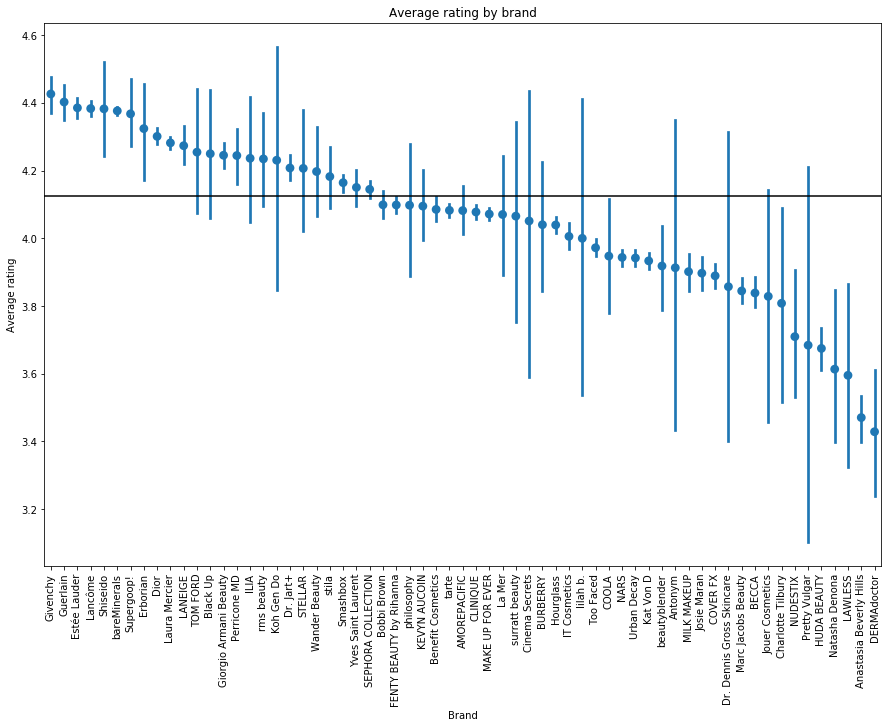

In [49]:
plt.figure(figsize = (15,10))
sns.pointplot(x = "brand", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("brand").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["brand"], join = False)
plt.title("Average rating by brand")
plt.xlabel("Brand")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)
plt.axhline(y=avg_rating, color='black', linestyle='-')

In [59]:
print(len(reviews[reviews["brand"] == "Givenchy"]))
print(len(reviews[reviews["brand"] == "Pretty Vulgar"]))

1451
19


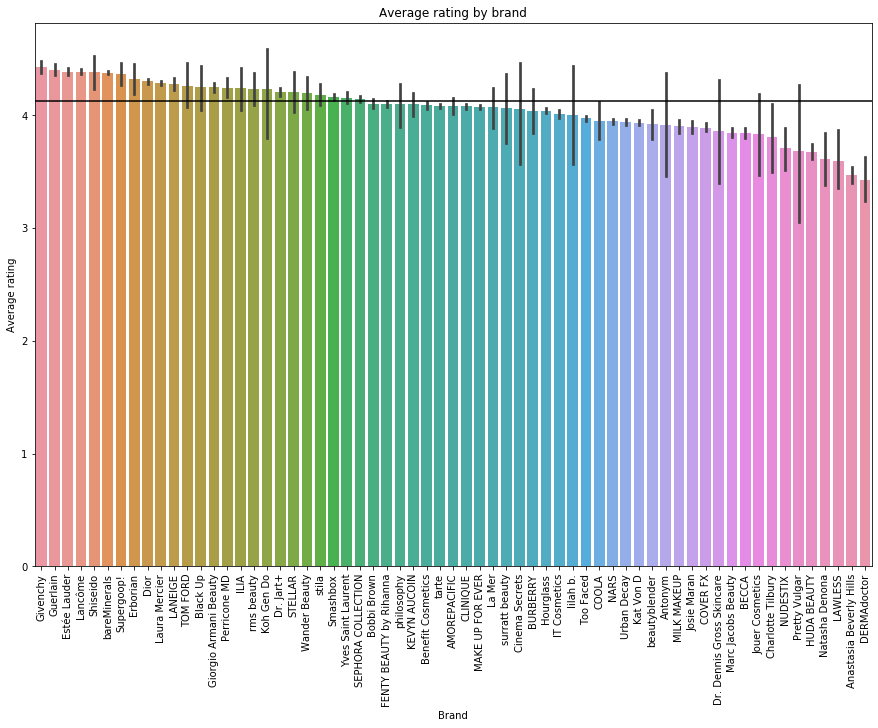

In [50]:
plt.figure(figsize = (15,10))
sns.barplot(x = "brand", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("brand").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["brand"])
plt.title("Average rating by brand")
plt.xlabel("Brand")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)
plt.axhline(y=avg_rating, color='black', linestyle='-')

25 brands have higher-than-average reviews.

In [55]:
print(len(reviews.groupby("brand").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)[reviews.groupby("brand").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["rating"] >= avg_rating]))
reviews.groupby("brand").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)[reviews.groupby("brand").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["rating"] >= avg_rating]

25


,brand,rating
21,Givenchy,4.426602
22,Guerlain,4.402725
18,Estée Lauder,4.385590
35,Lancôme,4.383528
47,Shiseido,4.382609
55,bareMinerals,4.376623
49,Supergoop!,4.367886
17,Erborian,4.324219
14,Dior,4.301243
36,Laura Mercier,4.282009


38 brands have lower-than-average reviews.

In [56]:
print(len(reviews.groupby("brand").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)[reviews.groupby("brand").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["rating"] < avg_rating]))
reviews.groupby("brand").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)[reviews.groupby("brand").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["rating"] < avg_rating]

38


,brand,rating
7,Bobbi Brown,4.099042
19,FENTY BEAUTY by Rihanna,4.098536
58,philosophy,4.097902
29,KEVYN AUCOIN,4.095164
5,Benefit Cosmetics,4.085400
62,tarte,4.082690
0,AMOREPACIFIC,4.081980
8,CLINIQUE,4.077772
37,MAKE UP FOR EVER,4.071698
34,La Mer,4.070423


We can also look at the relationship between price and average rating across brands. Doesn't seem like there is much of a pattern here.

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 <a list of 8 Text xticklabel objects>)

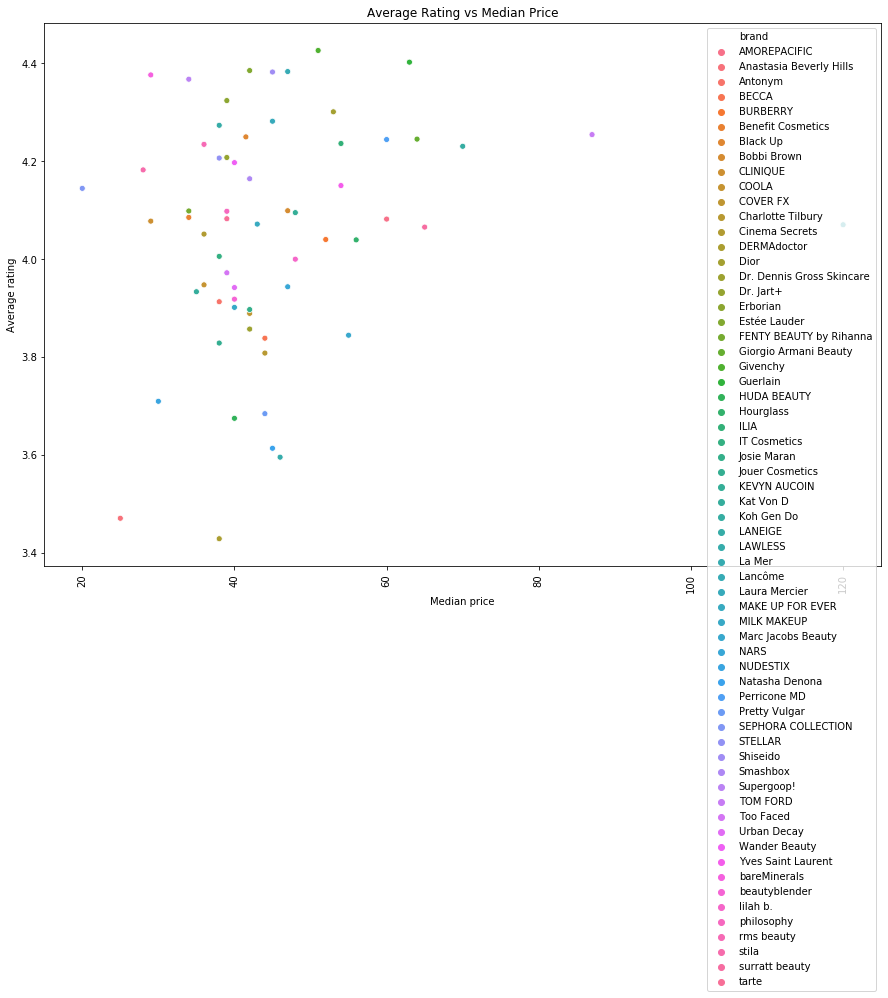

In [186]:
plt.figure(figsize = (15,10))
sns.scatterplot(x = "price", y = "rating", hue = reviews.groupby("brand").agg({"price": "median", "rating": "mean"}).index, data = reviews.groupby("brand").agg({"price": "median", "rating": "mean"}))
plt.title("Average Rating vs Median Price")
plt.xlabel("Median price")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)

We can also look at how well each individual product stacks up against the average rating. Again, this graph is not the easiest to read, but it just shows that foundations are stay pretty close to average rating, except at the two extremes. We have 98 products with above-average ratings and 119 products with below-average ratings.

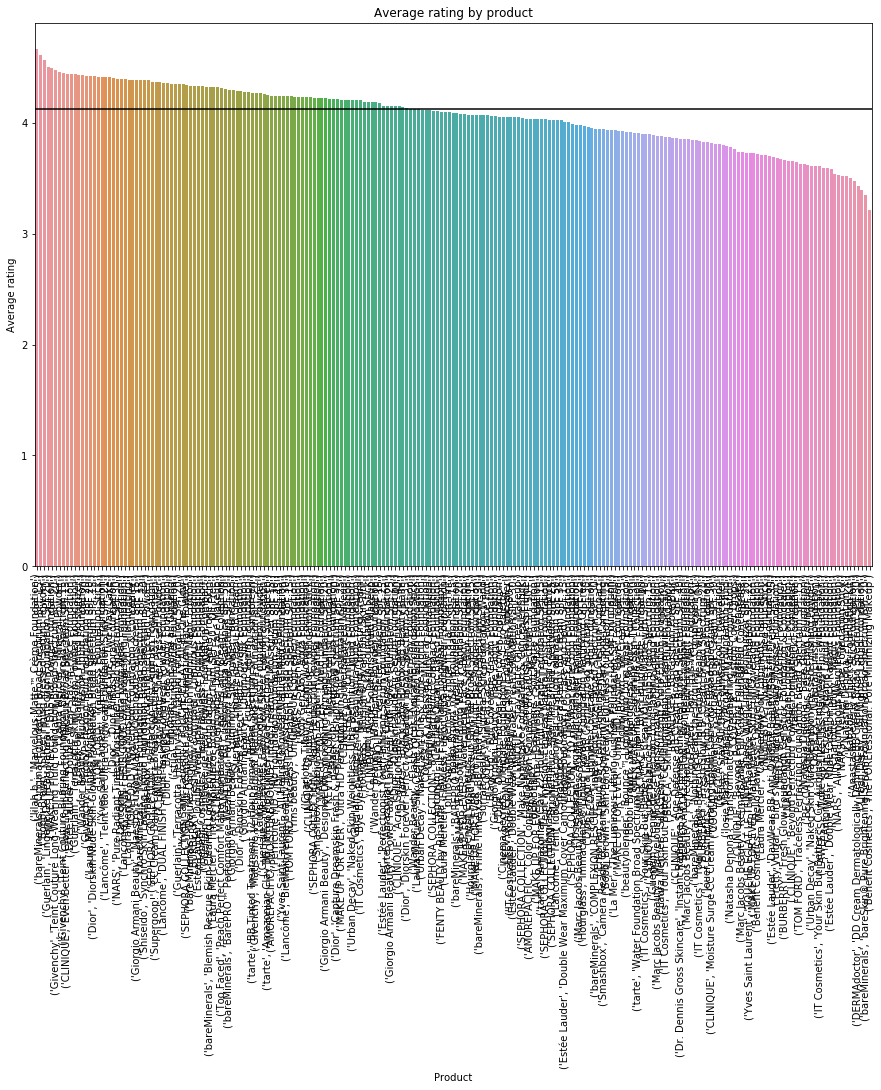

In [61]:
plt.figure(figsize = (15,10))
sns.barplot(x = reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False).index.to_series(), y = reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"], ci = None)
plt.title("Average rating by product")
plt.xlabel("Product")
plt.ylabel("Average rating")
plt.xticks(rotation = 90)
plt.axhline(y=avg_rating, color='black', linestyle='-')

98 products with higher-than-average ratings

In [71]:
print(len(pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] >= avg_rating])))
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] >= avg_rating])

98


,,rating
brand,name,
lilah b.,Marvelous Matte™ Crème Foundation,4.666667
bareMinerals,Original Foundation Broad Spectrum SPF 15,4.612741
Bobbi Brown,Sheer Finish Pressed Setting Powder,4.561086
Guerlain,Lingerie De Peau Natural Perfection Foundation SPF 20,4.500978
MAKE UP FOR EVER,Duo Mat Powder Foundation,4.496236
Givenchy,Teint Couture Long-Wearing Fluid Foundation Broad Spectrum SPF 20,4.473684
Laura Mercier,Mineral Powder,4.452290
Givenchy,Teint Couture Blurring Foundation Balm Broad Spectrum 15,4.444444
CLINIQUE,Even Better™ Glow Light Reflecting Makeup Broad Spectrum SPF 15,4.441176


10 highest-performing foundations

In [72]:
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] >= avg_rating]).head(10)

,,rating
brand,name,
lilah b.,Marvelous Matte™ Crème Foundation,4.666667
bareMinerals,Original Foundation Broad Spectrum SPF 15,4.612741
Bobbi Brown,Sheer Finish Pressed Setting Powder,4.561086
Guerlain,Lingerie De Peau Natural Perfection Foundation SPF 20,4.500978
MAKE UP FOR EVER,Duo Mat Powder Foundation,4.496236
Givenchy,Teint Couture Long-Wearing Fluid Foundation Broad Spectrum SPF 20,4.473684
Laura Mercier,Mineral Powder,4.452290
Givenchy,Teint Couture Blurring Foundation Balm Broad Spectrum 15,4.444444
CLINIQUE,Even Better™ Glow Light Reflecting Makeup Broad Spectrum SPF 15,4.441176


119 products with lower-than-average ratings

In [73]:
print(len(pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] < avg_rating])))
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] < avg_rating])

119


,,rating
brand,name,
Wander Beauty,Flash Focus Hydrating Foundation Stick,4.123711
Laura Mercier,Silk Crème Oil Free Photo Edition Foundation,4.123269
Urban Decay,Naked Skin One & Done Hybrid Foundation,4.114416
COVER FX,Pressed Mineral Foundation,4.112676
Giorgio Armani Beauty,Crema Nuda,4.111111
SEPHORA COLLECTION,8 HR Mattifying Compact Foundation,4.109560
Antonym,Certified Organic Baked Foundation,4.103448
FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,4.098536
Laura Mercier,Flawless Fusion Ultra-Longwear Foundation,4.097918


10 lowest-performing foundations

In [74]:
pd.DataFrame(reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"][reviews.groupby(["brand", "name"]).agg({"rating": "mean"}).sort_values(by = "rating", ascending = False)["rating"] < avg_rating]).tail(10)

rating
brand                   name                                                        
Charlotte Tilbury       Magic Foundation                                    3.533333
NARS                    All Day Luminous Weightless Foundation              3.526861
                        Velvet Matte Foundation Stick                       3.518692
Natasha Denona          Foundation X                                        3.515152
Kat Von D               Lock-It Foundation Kit                              3.500000
Anastasia Beverly Hills Stick Foundation                                    3.470391
DERMAdoctor             DD Cream Dermatologically Defining BB Cream Bro...  3.428571
Urban Decay             All Nighter Liquid Foundation                       3.396541
bareMinerals            bareSkin® Pure Brightening Serum Foundation Bro...  3.351675
Benefit Cosmetics       The POREfessional: Pore Minimizing Makeup           3.211538

<a id = "age_overview"></a>

### Age overview

It seems like ratings tend to increase with age.

In [187]:
reviews.groupby("age").agg({"rating": ["count", "mean"]})

rating          
        count      mean
age                    
13to17   5039  4.095059
18to24  34406  4.176917
25to34  42920  4.247018
35to44  18338  4.312902
45to54  11510  4.429192
over54   7333  4.433520

In [82]:
# plt.figure(figsize = (15,10))
# sns.pointplot(x = "age", y = "rating", data = reviews, estimator = np.mean, order = sorted(reviews["age"].dropna().unique()), join = False)
# plt.title("Average rating by age group")
# plt.xlabel("Age group")
# plt.ylabel("Average rating")
# plt.xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

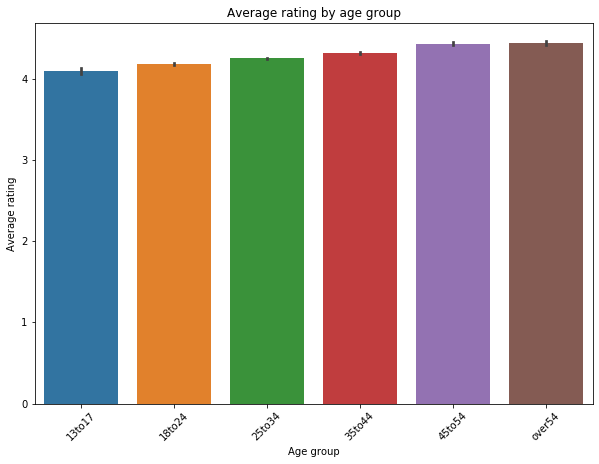

In [149]:
plt.figure(figsize = (10,7))
sns.barplot(x = "age", y = "rating", data = reviews, estimator = np.mean, order = sorted(reviews["age"].dropna().unique()))
plt.title("Average rating by age group")
plt.xlabel("Age group")
plt.ylabel("Average rating")
plt.xticks(rotation = 45)

<a id = "membership_status"></a>

### Membership status

We can also see how shoppers with different membership statuses rate foundations. Sephora tiers are: Beauty Insider, VIB, and VIB Rouge. Users with higher membership statuses tend to give lower ratings to foudnations. This makes sense to me since more frequent shoppers will probably be harsher with their reviews -- we have higher expectations!

In [86]:
reviews.groupby("beauty_insider").agg({"rating": "mean"})

,rating
beauty_insider,
no,4.412723
yes,4.338262
yesvib,4.064634
yesvibr,4.047964


In [90]:
# plt.figure(figsize = (10,7))
# sns.pointplot(x = "beauty_insider", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("beauty_insider").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["beauty_insider"], join = False)
# plt.title("Average rating by membership status")
# plt.xlabel("Membership status")
# plt.ylabel("Average rating")

Text(0, 0.5, 'Average rating')

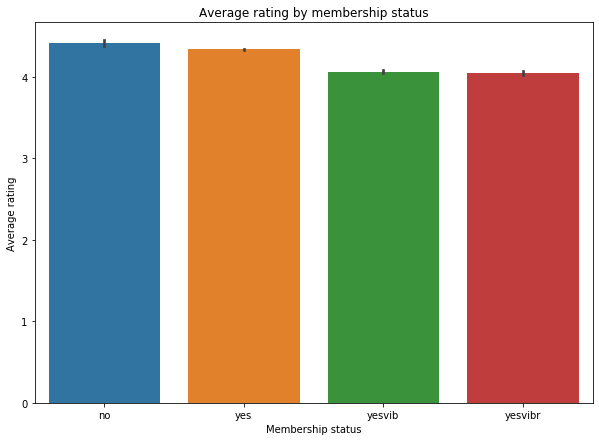

In [148]:
plt.figure(figsize = (10,7))
sns.barplot(x = "beauty_insider", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("beauty_insider").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["beauty_insider"])
plt.title("Average rating by membership status")
plt.xlabel("Membership status")
plt.ylabel("Average rating")

<a id = "foundation_characteristics"></a>

## Foundation characteristics

We can look at different characteristics of foundation: coverage, finish, formulation, and SPF. Out of all of these, coverage and finish are probably the more interesting characteristics to look at. Matte, full-coverage foundations have been in for a while, but there has been a surge in interest in lighter, dewier/radiant/natural foundations in the last year or so (think Glossier, Milk, yoga-skin -- "your skin but better").

Foundations can be light, medium, or full coverage. From the information that we have, it looks like our shoppers tend to prefer medium-coverage foundations. On average, full-coverage foundations are the most expensive, while light-coverage foundations are the cheapest.

In [209]:
reviews.groupby("coverage").agg({"rating": ["count", "mean"]})

rating          
          count      mean
coverage                 
Full      74856  3.977958
Light     16985  3.998822
Medium    96283  4.245962

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

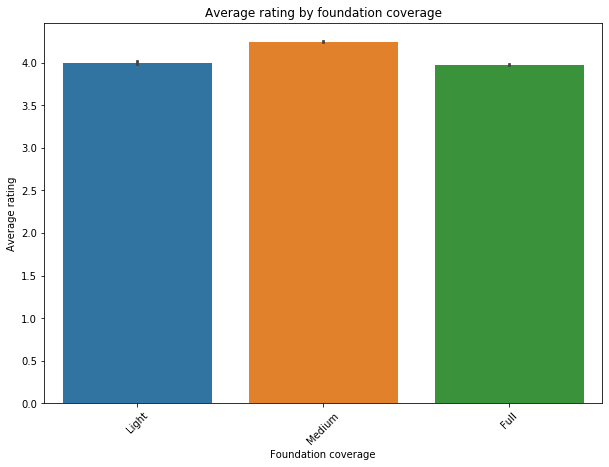

In [147]:
plt.figure(figsize = (10,7))
sns.barplot(x = "coverage", y = "rating", data = reviews, estimator = np.mean, order = ["Light", "Medium", "Full"])
plt.title("Average rating by foundation coverage")
plt.xlabel("Foundation coverage")
plt.ylabel("Average rating")
plt.xticks(rotation = 45)

In [95]:
reviews[["brand", "name", "coverage", "price"]].dropna().drop_duplicates().groupby("coverage").agg({"price": "mean"})

,price
coverage,
Full,48.250000
Light,39.894737
Medium,42.068182


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

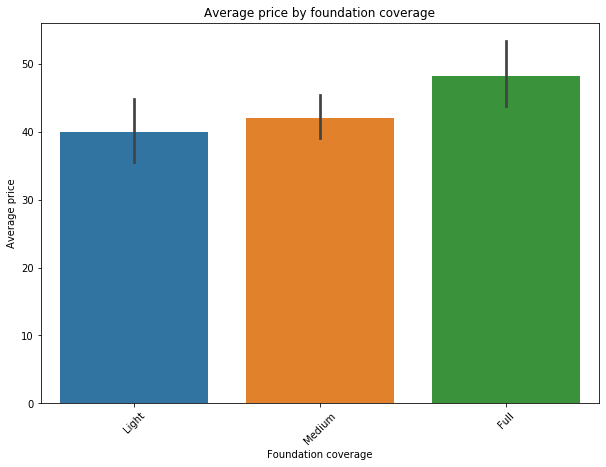

In [146]:
plt.figure(figsize = (10,7))
sns.barplot(x = "coverage", y = "price", data = reviews[["brand", "name", "coverage", "price"]].dropna().drop_duplicates(), estimator = np.mean, order = ["Light", "Medium", "Full"])
plt.title("Average price by foundation coverage")
plt.xlabel("Foundation coverage")
plt.ylabel("Average price")
plt.xticks(rotation = 45)

Looks like The People tend to like their radiant foundations, then matte foundations, then natural foundations. However, the reverse trend is found in relation to price--natural foundations are the most expensive while radiant foundations are the cheapest.

In [100]:
reviews.groupby("finish").agg({"rating": ["count", "mean"]})

rating          
         count      mean
finish                  
Matte    85560  4.167894
Natural  68026  3.989328
Radiant  33512  4.251969

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

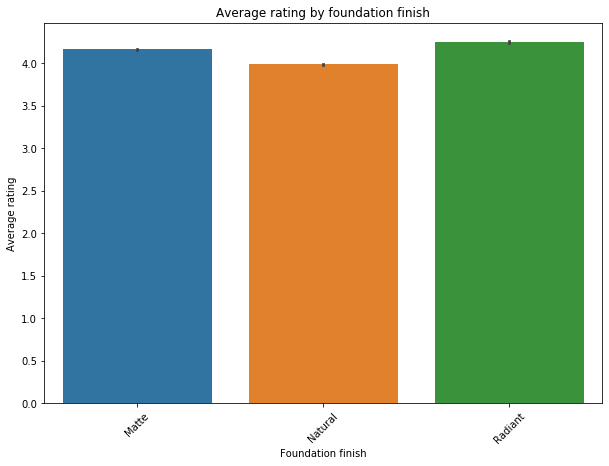

In [145]:
plt.figure(figsize = (10,7))
sns.barplot(x = "finish", y = "rating", data = reviews, estimator = np.mean, order = ["Matte", "Natural", "Radiant"])
plt.title("Average rating by foundation finish")
plt.xlabel("Foundation finish")
plt.ylabel("Average rating")
plt.xticks(rotation = 45)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

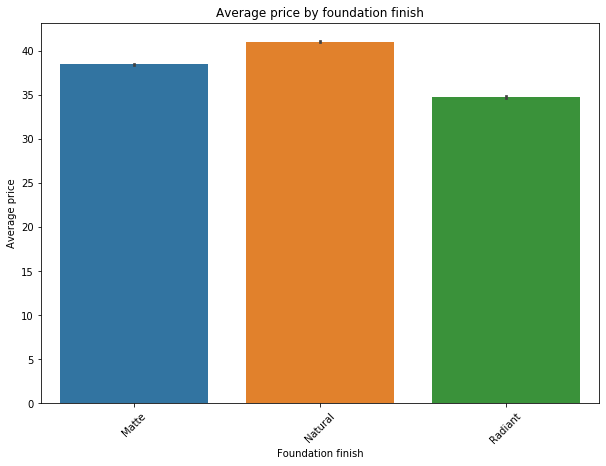

In [144]:
plt.figure(figsize = (10,7))
sns.barplot(x = "finish", y = "price", data = reviews, estimator = np.mean, order = ["Matte", "Natural", "Radiant"])
plt.title("Average price by foundation finish")
plt.xlabel("Foundation finish")
plt.ylabel("Average price")
plt.xticks(rotation = 45)

Most light-coverage foundations tend to have a natural finish, while most full-coverage foundations have a matte finish. This also isn't surprising, since radiant/natural foundations tend to not be as long-lasting. I am surprised that there aren't more reviews for radiant foundations, especially in the light/medium-coverage foundations, since dewy looks are trending. I don't know how old this dataset is, so it may be different today.

In [102]:
reviews.groupby(["coverage", "finish"]).agg({"rating": ["count", "mean"]})

rating          
                  count      mean
coverage finish                  
Full     Matte    42619  4.090265
         Natural  20400  3.881225
         Radiant  11837  3.740306
Light    Matte      151  4.072848
         Natural  15193  4.005200
         Radiant    576  3.916667
Medium   Matte    42790  4.245548
         Natural  32433  4.049887
         Radiant  21060  4.548765

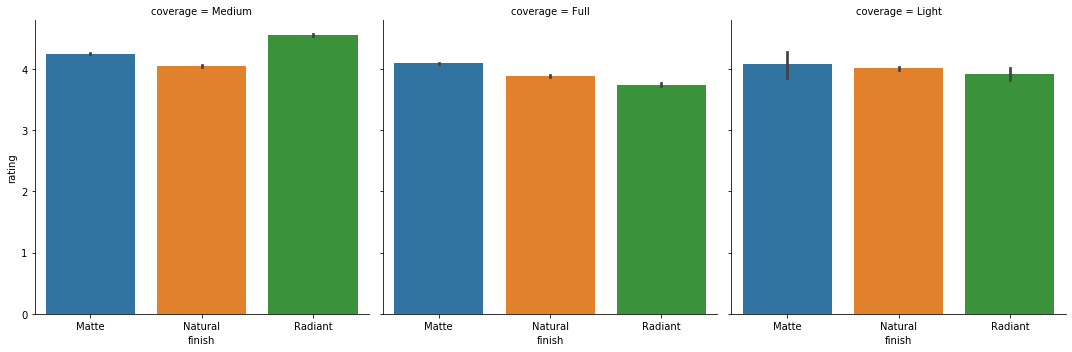

In [150]:
sns.catplot(x = "finish", y = "rating", col = "coverage", data = reviews, estimator = np.mean, kind = "bar", sharey = True)

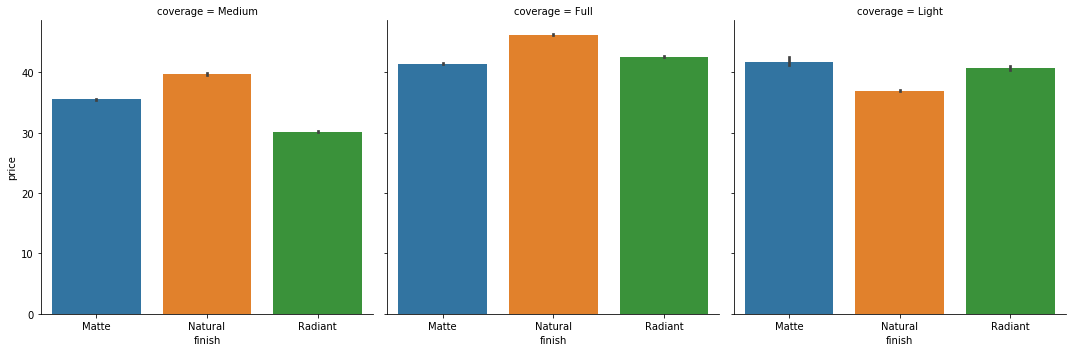

In [151]:
sns.catplot(x = "finish", y = "price", col = "coverage", data = reviews, estimator = np.mean, kind = "bar", sharey = True)

People like their SPF! But just a reminder that foundation/beauty products do not contain enough SPF so we should be wearing additional SPF :)

In [162]:
reviews.groupby("SPF").agg({"price": "mean", "rating": "mean"})

,price,rating
SPF,,
False,40.514337,4.055341
True,38.675586,4.244228


In [115]:
reviews.groupby(["age", "coverage"]).agg({"rating": ["count", "mean"]})

rating          
                 count      mean
age    coverage                 
13to17 Full       1253  3.883480
       Light       326  4.003067
       Medium     2014  4.199603
18to24 Full       8773  4.020404
       Light      2135  4.032787
       Medium    14058  4.294281
25to34 Full       8758  4.110413
       Light      3139  4.068493
       Medium    17531  4.364326
35to44 Full       2890  4.173702
       Light      1613  4.103534
       Medium     7585  4.444562
45to54 Full       1671  4.272292
       Light      1041  4.237272
       Medium     4783  4.579971
over54 Full       1052  4.240494
       Light       552  4.326087
       Medium     3010  4.569767

In [116]:
reviews.groupby(["age", "finish"]).agg({"rating": ["count", "mean"]})

rating          
                count      mean
age    finish                  
13to17 Matte     1567  4.086790
       Natural   1176  3.914966
       Radiant    850  4.260000
18to24 Matte    10457  4.222817
       Natural   8847  4.045891
       Radiant   5660  4.291519
25to34 Matte    11963  4.283708
       Natural  10150  4.095074
       Radiant   7312  4.439141
35to44 Matte     4576  4.352928
       Natural   4087  4.119892
       Radiant   3422  4.566335
45to54 Matte     2791  4.447152
       Natural   2313  4.237354
       Radiant   2391  4.700544
over54 Matte     1626  4.364084
       Natural   1398  4.254649
       Radiant   1590  4.752830

Formulation

In [119]:
reviews["formulation"].value_counts()

Liquid         105485
Loose           27035
Pressed          7502
Stick            7446
Cream            6827
LiquidStick         2
Name: formulation, dtype: int64

Checked online and the foundation "LiquidStick" is actually a liquid, so I just renamed it.

In [120]:
reviews.loc[reviews["formulation"] == "LiquidStick", "formulation"] = "Liquid"

In [121]:
reviews["formulation"].value_counts()

Liquid     105487
Loose       27035
Pressed      7502
Stick        7446
Cream        6827
Name: formulation, dtype: int64

Surprisingly, loose foundations have the highest performance. Maybe I should go check out bareMinerals.

In [122]:
reviews.groupby("formulation").agg({"rating": "mean"})

,rating
formulation,
Cream,4.199648
Liquid,4.027122
Loose,4.546884
Pressed,4.351373
Stick,4.026189


Text(0, 0.5, 'Average rating')

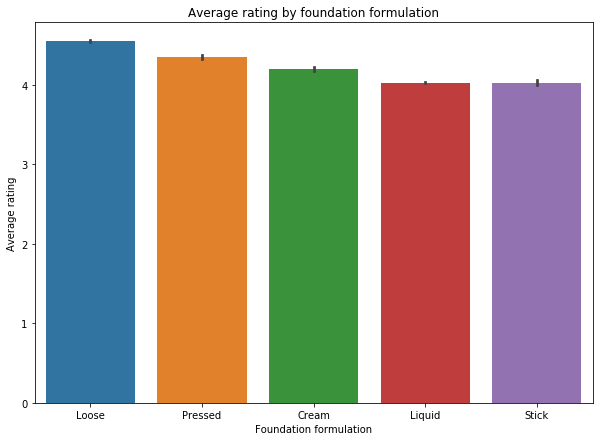

In [129]:
plt.figure(figsize = (10,7))
sns.barplot(x = "formulation", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("formulation").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["formulation"])
plt.title("Average rating by foundation formulation")
plt.xlabel("Foundation formulation")
plt.ylabel("Average rating")

Text(0, 0.5, 'Average price')

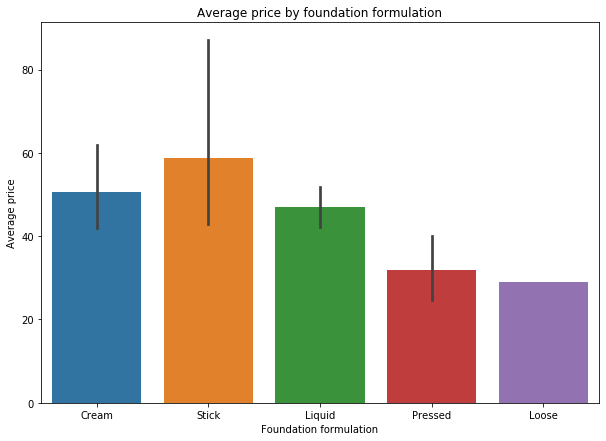

In [169]:
plt.figure(figsize = (10,7))
sns.barplot(x = "formulation", y = "price", data = reviews[["brand", "name", "formulation", "price"]].dropna().drop_duplicates(), estimator = np.mean, order = reviews.groupby("formulation").agg({"price": "mean"}).reset_index().sort_values(by = "price", ascending = False)["formulation"])
plt.title("Average price by foundation formulation")
plt.xlabel("Foundation formulation")
plt.ylabel("Average price")

In [69]:
reviews[reviews["formulation"] == "Loose"][["brand", "name"]].drop_duplicates()

,brand,name
43998,bareMinerals,Original Foundation Broad Spectrum SPF 15
119844,bareMinerals,Matte Foundation Broad Spectrum SPF 15


Skin type doesn't tell us much

In [71]:
reviews.groupby(["skin_type"]).agg({"rating": ["count", "mean"]})

rating          
             count      mean
skin_type                   
combination  70739  4.095520
dry          21060  4.058025
normal       17568  4.121699
oily         24996  4.049488

Skin tone

In [72]:
reviews["skin_tone"].value_counts()

light        55695
medium       47626
fair         38879
olive        16050
deep          7735
tan           6385
porcelain     6190
dark          3687
ebony          600
Name: skin_tone, dtype: int64

In [73]:
reviews.groupby("skin_tone").agg({"rating": "mean"})

,rating
skin_tone,
dark,4.288310
deep,4.297091
ebony,4.401667
fair,4.077651
light,4.185385
medium,4.274829
olive,4.263053
porcelain,3.758805
tan,4.215035


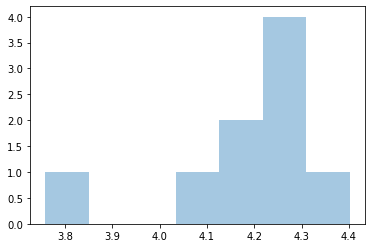

In [74]:
sns.distplot(reviews.groupby("skin_tone").agg({"rating": "mean"}), kde = False)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

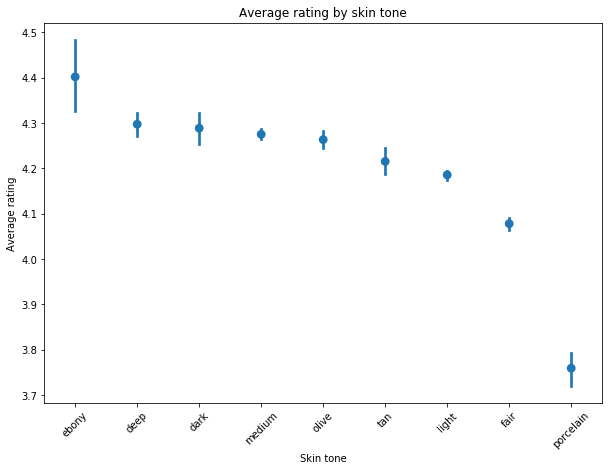

In [171]:
plt.figure(figsize = (10,7))
sns.pointplot(x = "skin_tone", y = "rating", data = reviews, estimator = np.mean, order = reviews.groupby("skin_tone").agg({"rating": "mean"}).reset_index().sort_values(by = "rating", ascending = False)["skin_tone"], join = False)
plt.title("Average rating by skin tone")
plt.xlabel("Skin tone")
plt.ylabel("Average rating")
plt.xticks(rotation = 45)

In [75]:
reviews[reviews["skin_tone"] == "porcelain"].groupby(["brand", "name"]).agg({"rating": ["count","mean"]})["rating"].sort_values(by = "count", ascending = False)

count  \
brand                   name                                                        
FENTY BEAUTY by Rihanna Pro Filt'r Soft Matte Longwear Foundation             877   
Kat Von D               Lock-It Foundation                                    406   
Too Faced               Born This Way Foundation                              257   
                        Peach Perfect Comfort Matte Foundation – Peache...    242   
MAKE UP FOR EVER        Ultra HD Invisible Cover Foundation                   213   
...                                                                           ...   
Erborian                Liquid BB Crème Au Ginseng Cushion Compact              1   
Estée Lauder            Double Wear Nude Cushion Stick Radiant Foundation       1   
Bobbi Brown             Sheer Finish Pressed Setting Powder                     1   
Marc Jacobs Beauty      Marvelous Mousse Transformative OilFree Founda...      1   
MAKE UP FOR EVER        Liquid Lift Foundation                                  1   

                                                                                mean  
brand                   name                                                          
FENTY BEAUTY by Rihanna Pro Filt'r Soft Matte Longwear Foundation           3.393387  
Kat Von D               Lock-It Foundation                                  3.665025  
Too Faced               Born This Way Foundation                            3.813230  
                        Peach Perfect Comfort Matte Foundation – Peache...  4.086777  
MAKE UP FOR EVER        Ultra HD Invisible Cover Foundation                 3.830986  
...                                                                              ...  
Erborian                Liquid BB Crème Au Ginseng Cushion Compact          5.000000  
Estée Lauder            Double Wear Nude Cushion Stick Radiant Foundation   3.000000  
Bobbi Brown             Sheer Finish Pressed Setting Powder                 2.000000  
Marc Jacobs Beauty      Marvelous Mousse Transformative OilFree Founda...  5.000000  
MAKE UP FOR EVER        Liquid Lift Foundation                              1.000000  

[187 rows x 2 columns]

In [76]:
reviews[reviews["skin_tone"] == "ebony"].groupby(["brand", "name"]).agg({"rating": ["count","mean"]})["rating"].sort_values(by = "count", ascending = False)

,,count,mean
brand,name,,
FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,163,4.705521
MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,31,4.290323
Kat Von D,Lock-It Foundation,27,4.407407
BECCA,Ultimate Coverage 24-Hour Foundation,26,4.307692
NARS,Natural Radiant Longwear Foundation,23,3.913043
Marc Jacobs Beauty,Shameless Youthful-Look 24H Foundation SPF 25,19,4.421053
COVER FX,Power Play Foundation,16,4.500000
Lancôme,Teint Idole Ultra Long Wear Foundation,16,5.000000
Too Faced,Born This Way Foundation,15,4.466667


<a id = "incentivized"></a>

### Incentivized Reviews

One thing that's pretty big in the beauty industry is getting free/sponsored products, so I think it'd be pretty interesting to see how this affects product ratings. Let's make the VERY strong assumption that customers are being honest about whether they are leaving an incentivized review (i.e. they received the product for free to leave an honest review). Only ~4000 user reviews have are marked as incentivized reviews, yet the average rating is 0.3 higher for these reviews than for un-incentivized reviews.

In [172]:
reviews["incentivized_review"].value_counts()

False    75319
True      4104
Name: incentivized_review, dtype: int64

In [173]:
reviews.groupby("incentivized_review").agg({"rating": "mean"})

,rating
incentivized_review,
False,3.902256
True,4.206871


In all age groups except "over54", we can see that users gave higher ratings on average if they received a product for free. We can also see that the bulk of our incentivized reviewers are under the age brackets "18-22" and "25-34", which is typically how old influencers are.

In [180]:
reviews.groupby(["age", "incentivized_review"]).agg({"rating": ["count", "mean"]})

rating          
                            count      mean
age    incentivized_review                 
13to17 False                 1245  3.795181
       True                    80  3.912500
18to24 False                 9535  3.930572
       True                  1438  4.269124
25to34 False                 8914  3.986201
       True                  1612  4.240695
35to44 False                 2749  4.052383
       True                   399  4.157895
45to54 False                 1587  4.243856
       True                   139  4.352518
over54 False                  868  4.243088
       True                    52  3.923077

Text(0, 0.5, 'Average rating')

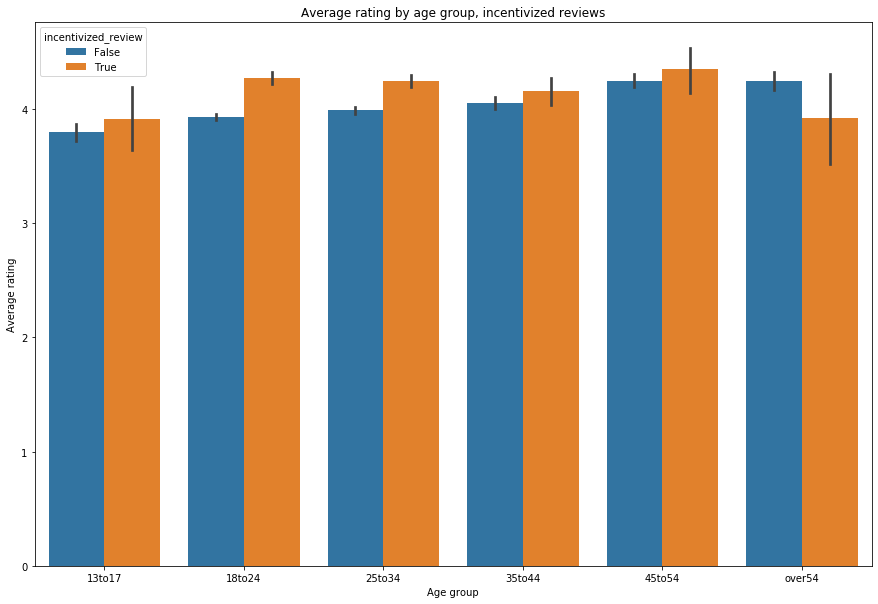

In [258]:
plt.figure(figsize = (15,10))
sns.barplot(x = "age", y = "rating", hue = "incentivized_review", data = reviews, estimator = np.mean, order = sorted(reviews["age"].dropna().unique()))
plt.title("Average rating by age group, incentivized reviews")
plt.xlabel("Age group")
plt.ylabel("Average rating")

Text(0, 0.5, 'Number of users')

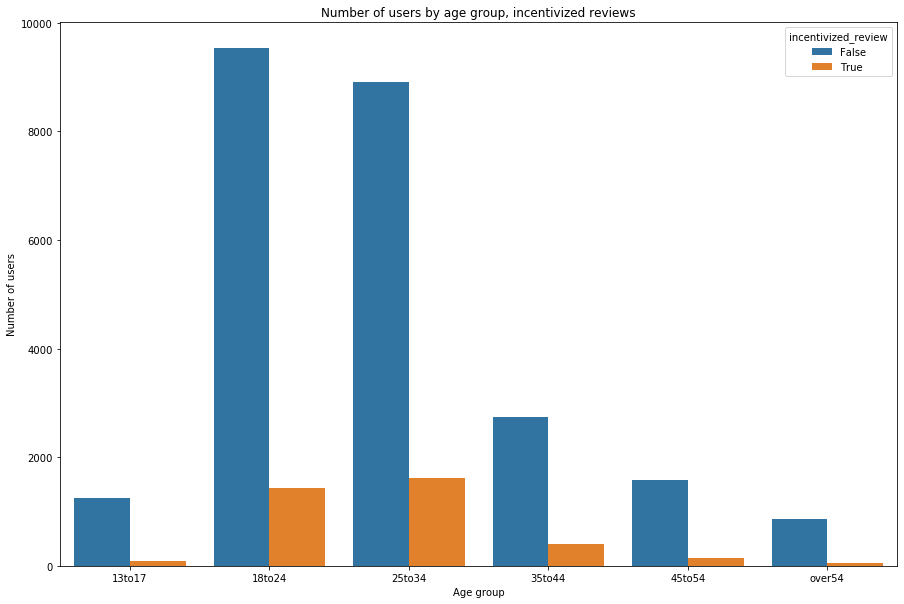

In [264]:
plt.figure(figsize = (15,10))
sns.countplot(x = "age", hue = "incentivized_review", data = reviews, order = sorted(reviews["age"].dropna().unique()))
plt.title("Number of users by age group, incentivized reviews")
plt.xlabel("Age group")
plt.ylabel("Number of users")

Across all membership statuses, we can see that users gave higher ratings on average if they received a free product, with most users having a regular membership status.

In [187]:
reviews.groupby(["beauty_insider", "incentivized_review"]).agg({"rating": ["count", "mean"]})

rating          
                                    count      mean
beauty_insider incentivized_review                 
no             False                  498  3.901606
               True                   189  4.550265
yes            False                 9412  3.980663
               True                  1860  4.293011
yesvib         False                 8277  3.991422
               True                   941  4.166844
yesvibr        False                 6955  3.984184
               True                   742  4.092992

Text(0, 0.5, 'Average rating')

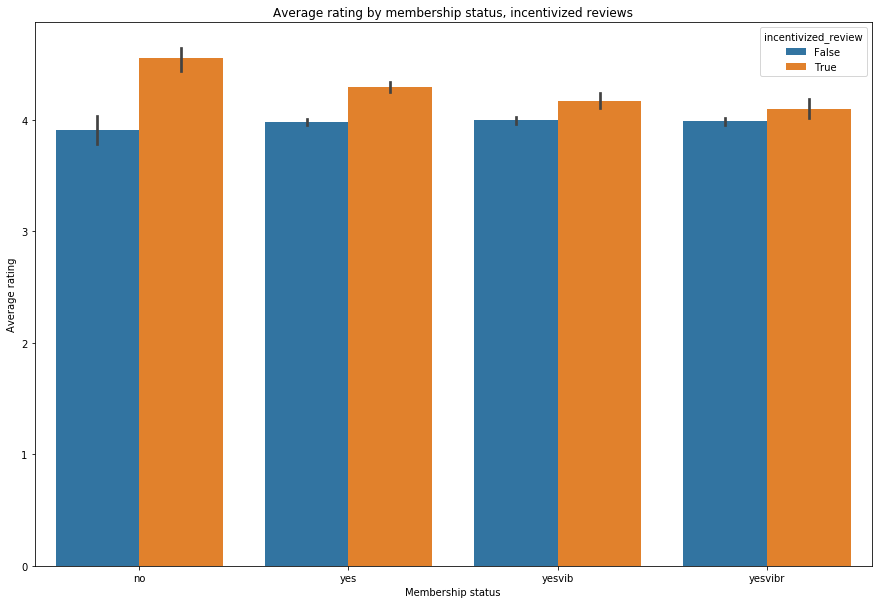

In [189]:
plt.figure(figsize = (15,10))
sns.barplot(x = "beauty_insider", y = "rating", hue = "incentivized_review", data = reviews, estimator = np.mean, order = ["no", "yes", "yesvib", "yesvibr"])
plt.title("Average rating by membership status, incentivized reviews")
plt.xlabel("Membership status")
plt.ylabel("Average rating")

Text(0, 0.5, 'Number of users')

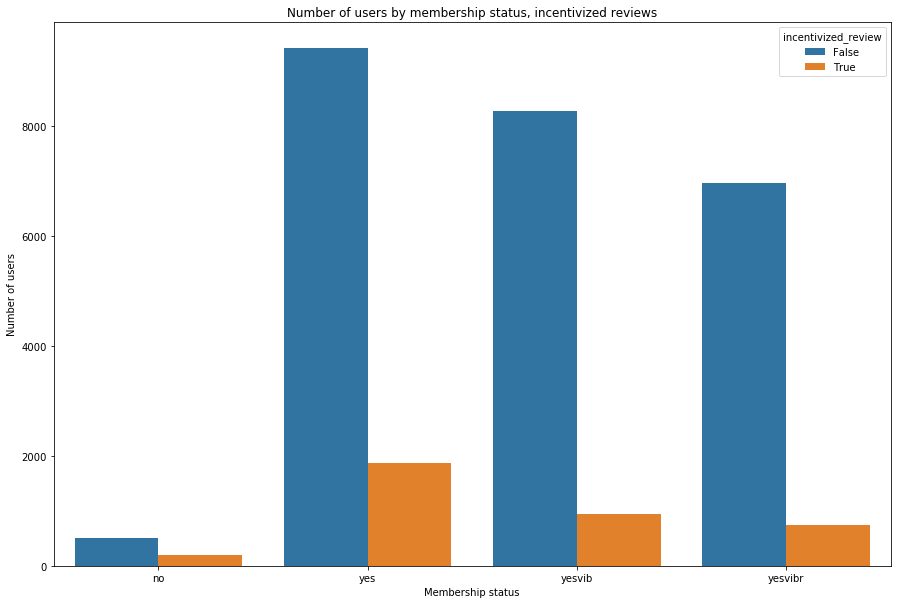

In [193]:
plt.figure(figsize = (15,10))
sns.countplot(x = "beauty_insider", hue = "incentivized_review", data = reviews, order = ["no", "yes", "yesvib", "yesvibr"])
plt.title("Number of users by membership status, incentivized reviews")
plt.xlabel("Membership status")
plt.ylabel("Number of users")

## Reviews

We can also take a look at some of the review text. I'm not doing anything too crazy, but we can try some (very basic) sentiment analysis across the board.

In [195]:
reviews["clean_review_text"] = deepcopy(reviews["review_text"])

In [196]:
reviews["clean_review_text"] = reviews["clean_review_text"].str.lower().str.replace('[^\w\s]','').str.strip()

Tokenize

In [197]:
tokenizer = RegexpTokenizer(r"\w+")

In [198]:
reviews["clean_review_text"] = reviews["clean_review_text"].apply(lambda text: tokenizer.tokenize(text))

Removing stopwords

In [199]:
stop = set(stopwords.words("english"))

In [200]:
reviews["clean_review_text"] = reviews["clean_review_text"].apply(lambda w: [w for w in w if w not in stop])

In [201]:
reviews["polarity"] = reviews["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [202]:
reviews["subjectivity"] = reviews["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [249]:
reviews[["polarity", "subjectivity"]].describe()

,polarity,subjectivity
count,275950.000000,275950.000000
mean,0.280898,0.577029
std,0.225974,0.144403
min,-1.000000,0.000000
25%,0.150000,0.500000
50%,0.270476,0.577937
75%,0.404640,0.660000
max,1.000000,1.000000


In [250]:
avg_polarity = reviews["polarity"].mean()
avg_subjectivity = reviews["subjectivity"].mean()

There doesn't seem to be too much of a difference in polarity or subjectivity based on whether a review was incentivized or not. There may be a slight increase in positive sentiment for incentivized reviews, but it's quite small.

In [100]:
reviews.groupby("incentivized_review").agg({"polarity": "mean", "subjectivity": "mean"})

,polarity,subjectivity
incentivized_review,,
False,0.253820,0.578058
True,0.279683,0.587841


Text(0, 0.5, 'Density')

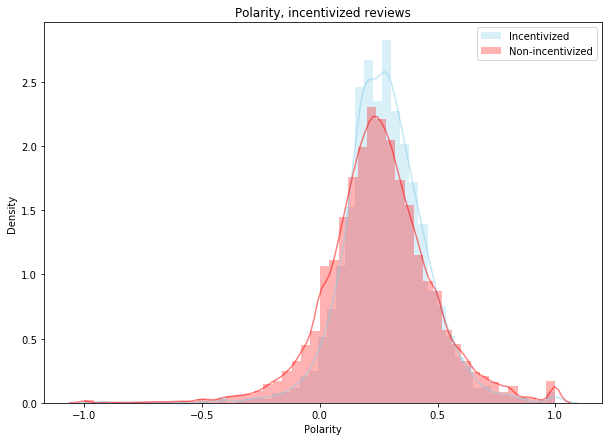

In [237]:
plt.figure(figsize = (10,7))
sns.distplot(reviews[reviews["incentivized_review"] == True]["polarity"], color="skyblue", label="Incentivized", kde_kws={"alpha": 0.5}, hist_kws={"alpha": 0.3})
sns.distplot(reviews[reviews["incentivized_review"] == False]["polarity"], color="red", label="Non-incentivized", kde_kws={"alpha": 0.5}, hist_kws={"alpha": 0.3})
plt.legend()
plt.title("Polarity, incentivized reviews")
plt.xlabel("Polarity")
plt.ylabel("Density")

Text(0, 0.5, 'Density')

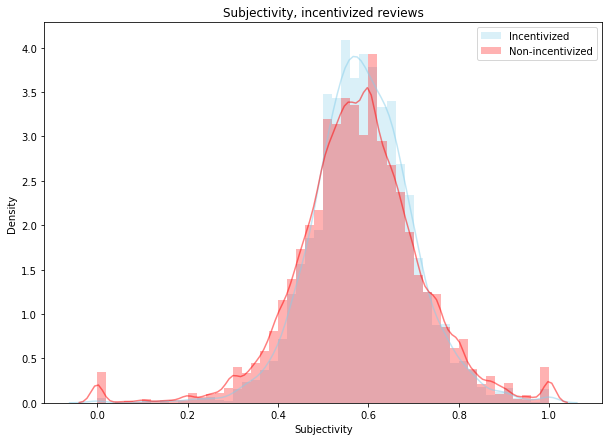

In [238]:
plt.figure(figsize = (10,7))
sns.distplot(reviews[reviews["incentivized_review"] == True]["subjectivity"], color="skyblue", label="Incentivized", kde_kws={"alpha": 0.5}, hist_kws={"alpha": 0.3})
sns.distplot(reviews[reviews["incentivized_review"] == False]["subjectivity"], color="red", label="Non-incentivized", kde_kws={"alpha": 0.5}, hist_kws={"alpha": 0.3})
plt.legend()
plt.title("Subjectivity, incentivized reviews")
plt.xlabel("Subjectivity")
plt.ylabel("Density")

Looking at polarity in relation to age, it seems like there is a slight increase in polarity/positive sentiment with age, which goes along with our observation that ratings increased with age. Definitely a subtle effect, but it's there. However, subjectivity remains pretty constant with age.

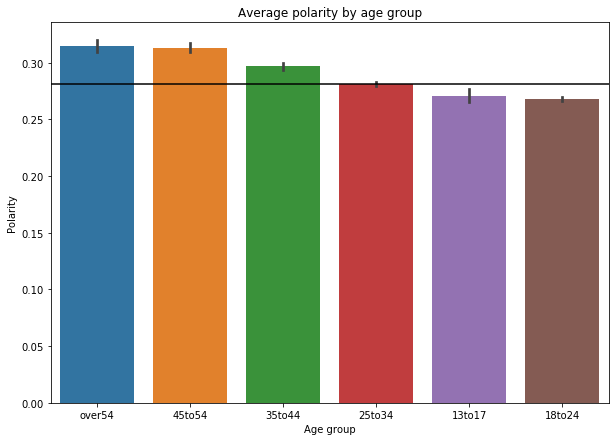

In [251]:
plt.figure(figsize = (10, 7))
sns.barplot(x = "age", y = "polarity", data = reviews, estimator = np.mean, order = reviews.groupby("age").agg({"polarity": "mean"}).reset_index().sort_values(by = "polarity", ascending = False)["age"])
plt.title("Average polarity by age group")
plt.xlabel("Age group")
plt.ylabel("Polarity")
plt.axhline(y=avg_polarity, color='black', linestyle='-')

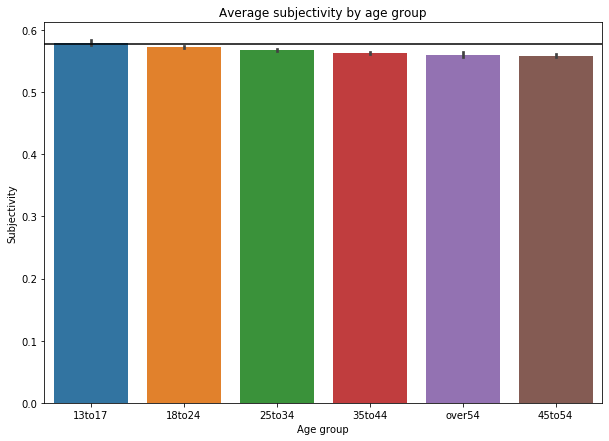

In [252]:
plt.figure(figsize = (10,7))
sns.barplot(x = "age", y = "subjectivity", data = reviews, estimator = np.mean, order = reviews.groupby("age").agg({"subjectivity": "mean"}).reset_index().sort_values(by = "subjectivity", ascending = False)["age"])
plt.title("Average subjectivity by age group")
plt.xlabel("Age group")
plt.ylabel("Subjectivity")
plt.axhline(y=avg_subjectivity, color='black', linestyle='-')

In [244]:
# plt.figure(figsize = (10,7))
# sns.distplot(reviews[reviews["age"] == "13to17"]["polarity"], color="red", label="13to17", kde_kws={"alpha": 0.3}, hist_kws={"alpha": 0.1})
# sns.distplot(reviews[reviews["age"] == "18to24"]["polarity"], color="orange", label="18to24", kde_kws={"alpha": 0.3}, hist_kws={"alpha": 0.1})
# sns.distplot(reviews[reviews["age"] == "25to34"]["polarity"], color="yellow", label="25to34", kde_kws={"alpha": 0.3}, hist_kws={"alpha": 0.1})
# sns.distplot(reviews[reviews["age"] == "35to44"]["polarity"], color="green", label="35to44", kde_kws={"alpha": 0.3}, hist_kws={"alpha": 0.1})
# sns.distplot(reviews[reviews["age"] == "45to54"]["polarity"], color="blue", label="45to54", kde_kws={"alpha": 0.3}, hist_kws={"alpha": 0.1})
# sns.distplot(reviews[reviews["age"] == "over54"]["polarity"], color="purple", label="over54", kde_kws={"alpha": 0.3}, hist_kws={"alpha": 0.1})
# plt.legend()
# plt.title("Polarity, age")
# plt.xlabel("Polarity")
# plt.ylabel("Density")

In [245]:
# plt.figure(figsize = (10,7))
# sns.distplot(reviews[reviews["age"] == "13to17"]["subjectivity"], color="red", label="13to17", kde_kws={"alpha": 0.3}, hist_kws={"alpha": 0.1})
# sns.distplot(reviews[reviews["age"] == "18to24"]["subjectivity"], color="orange", label="18to24", kde_kws={"alpha": 0.3}, hist_kws={"alpha": 0.1})
# sns.distplot(reviews[reviews["age"] == "25to34"]["subjectivity"], color="yellow", label="25to34", kde_kws={"alpha": 0.3}, hist_kws={"alpha": 0.1})
# sns.distplot(reviews[reviews["age"] == "35to44"]["subjectivity"], color="green", label="35to44", kde_kws={"alpha": 0.3}, hist_kws={"alpha": 0.1})
# sns.distplot(reviews[reviews["age"] == "45to54"]["subjectivity"], color="blue", label="45to54", kde_kws={"alpha": 0.3}, hist_kws={"alpha": 0.1})
# sns.distplot(reviews[reviews["age"] == "over54"]["subjectivity"], color="purple", label="over54", kde_kws={"alpha": 0.3}, hist_kws={"alpha": 0.1})
# plt.legend()
# plt.title("Subjectivity, age")
# plt.xlabel("Subjectivity")
# plt.ylabel("Density")

Looks like Laneige is doing pretty well! Pretty Vulgar, on the other hand, is not doing so hot with the Sephora crowd.

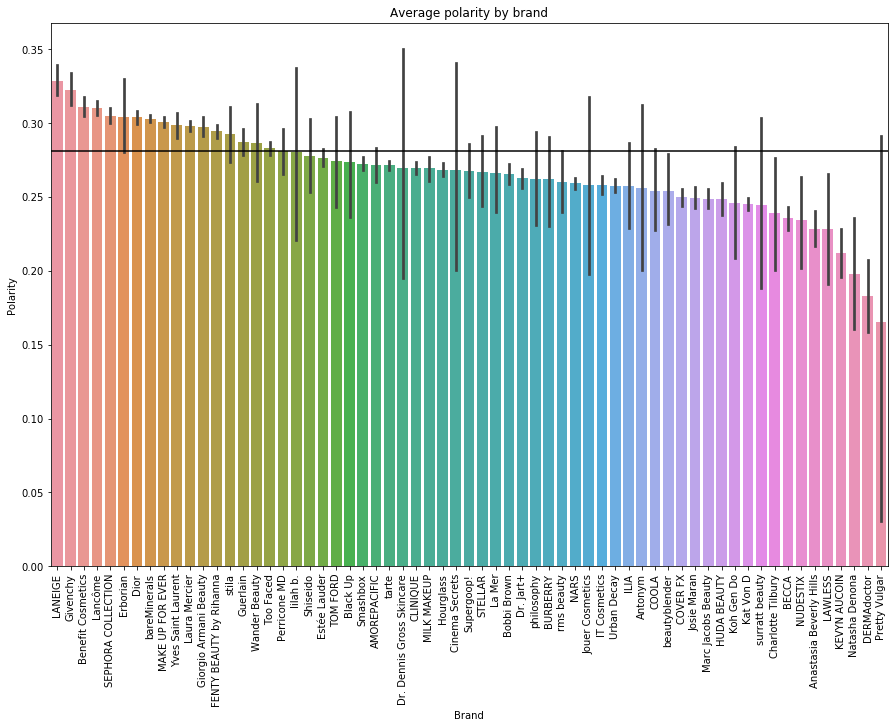

In [253]:
plt.figure(figsize = (15,10))
sns.barplot(x = "brand", y = "polarity", data = reviews, estimator = np.mean, order = reviews.groupby("brand").agg({"polarity": "mean"}).reset_index().sort_values(by = "polarity", ascending = False)["brand"])
plt.title("Average polarity by brand")
plt.xlabel("Brand")
plt.ylabel("Polarity")
plt.xticks(rotation = 90)
plt.axhline(y=avg_polarity, color='black', linestyle='-')

18 brands have above-average polarity

In [257]:
print(len(reviews.groupby("brand").agg({"polarity": "mean"}).reset_index().sort_values(by = "polarity", ascending = False)[reviews.groupby("brand").agg({"polarity": "mean"}).reset_index().sort_values(by = "polarity", ascending = False)["polarity"] >= avg_polarity]))
reviews.groupby("brand").agg({"polarity": "mean"}).reset_index().sort_values(by = "polarity", ascending = False)[reviews.groupby("brand").agg({"polarity": "mean"}).reset_index().sort_values(by = "polarity", ascending = False)["polarity"] >= avg_polarity]

18


,brand,polarity
32,LANEIGE,0.328474
21,Givenchy,0.322600
5,Benefit Cosmetics,0.310879
35,Lancôme,0.310176
45,SEPHORA COLLECTION,0.305083
17,Erborian,0.303798
14,Dior,0.303750
55,bareMinerals,0.302997
37,MAKE UP FOR EVER,0.300586
54,Yves Saint Laurent,0.298464


45 brands have above-average polarity

In [258]:
print(len(reviews.groupby("brand").agg({"polarity": "mean"}).reset_index().sort_values(by = "polarity", ascending = False)[reviews.groupby("brand").agg({"polarity": "mean"}).reset_index().sort_values(by = "polarity", ascending = False)["polarity"] < avg_polarity]))
reviews.groupby("brand").agg({"polarity": "mean"}).reset_index().sort_values(by = "polarity", ascending = False)[reviews.groupby("brand").agg({"polarity": "mean"}).reset_index().sort_values(by = "polarity", ascending = False)["polarity"] < avg_polarity]

45


,brand,polarity
57,lilah b.,0.280565
47,Shiseido,0.277721
18,Estée Lauder,0.276499
50,TOM FORD,0.274504
6,Black Up,0.273557
48,Smashbox,0.272444
0,AMOREPACIFIC,0.271913
62,tarte,0.271307
15,Dr. Dennis Gross Skincare,0.269877
8,CLINIQUE,0.269834


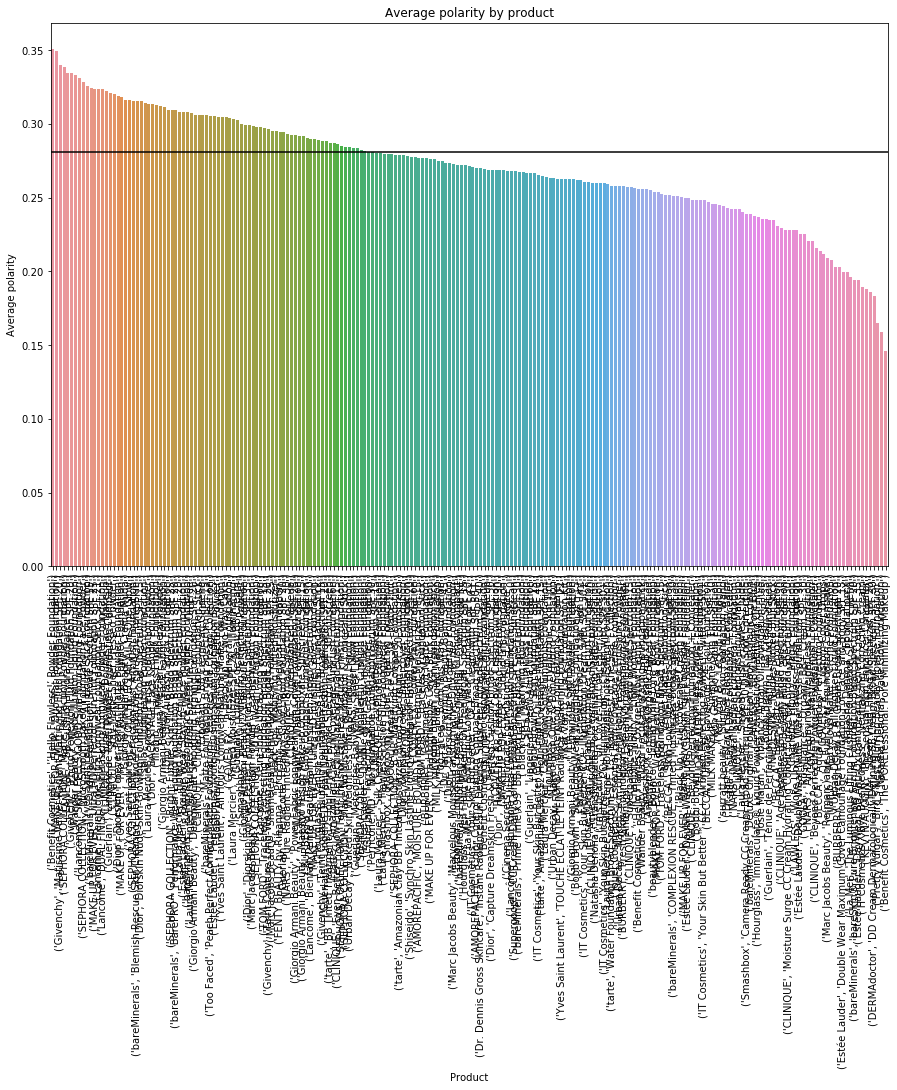

In [254]:
plt.figure(figsize = (15,10))
sns.barplot(x = reviews.groupby(["brand", "name"]).agg({"polarity": "mean"}).sort_values(by = "polarity", ascending = False).index.to_series(), y = reviews.groupby(["brand", "name"]).agg({"polarity": "mean"}).sort_values(by = "polarity", ascending = False)["polarity"], ci = None)
plt.title("Average polarity by product")
plt.xlabel("Product")
plt.ylabel("Average polarity")
plt.xticks(rotation = 90)
plt.axhline(y=avg_polarity, color='black', linestyle='-')

84 products have above-average polarity

In [284]:
print(len(reviews.groupby(["brand", "name"]).agg({"polarity": ["mean", "std"]})["polarity"].sort_values(by = "mean", ascending = False)[reviews.groupby(["brand", "name"]).agg({"polarity": ["mean", "std"]})["polarity"].sort_values(by = "mean", ascending = False)["mean"] >= avg_polarity]))
reviews.groupby(["brand", "name"]).agg({"polarity": ["mean", "std"]})["polarity"].sort_values(by = "mean", ascending = False)[reviews.groupby(["brand", "name"]).agg({"polarity": ["mean", "std"]})["polarity"].sort_values(by = "mean", ascending = False)["mean"] >= avg_polarity]

84


,,mean,std
brand,name,,
Benefit Cosmetics,’Hello Flawless!’ Powder Foundation,0.351054,0.233273
MAKE UP FOR EVER,Duo Mat Powder Foundation,0.349287,0.245036
Givenchy,Matissime Velvet Radiant Mattifying Fluid Foundation SPF 20,0.340246,0.200683
SEPHORA COLLECTION,Matte Perfection Powder Foundation,0.338737,0.270026
LANEIGE,BB Cushion Hydra Radiance SPF 50,0.334702,0.180434
Givenchy,Photo’Perfexion Fluid Foundation SPF 20,0.334457,0.218073
Wander Beauty,Nude Illusion Liquid Foundation,0.333221,0.218940
Lancôme,SKIN FEELS GOOD Skin Nourishing Foundation,0.331189,0.171728
SEPHORA COLLECTION,MicroSmooth Baked Foundation Face Powder,0.328274,0.246987


133 products have above-average polarity

In [285]:
print(len(reviews.groupby(["brand", "name"]).agg({"polarity": ["mean", "std"]})["polarity"].sort_values(by = "mean", ascending = False)[reviews.groupby(["brand", "name"]).agg({"polarity": ["mean", "std"]})["polarity"].sort_values(by = "mean", ascending = False)["mean"] < avg_polarity]))
reviews.groupby(["brand", "name"]).agg({"polarity": ["mean", "std"]})["polarity"].sort_values(by = "mean", ascending = False)[reviews.groupby(["brand", "name"]).agg({"polarity": ["mean", "std"]})["polarity"].sort_values(by = "mean", ascending = False)["mean"] < avg_polarity]

133


mean  \
brand             name                                                           
CLINIQUE          Even Better Makeup SPF 15                           0.280522   
Laura Mercier     Silk Crème Oil Free Photo Edition Foundation        0.280069   
                  Flawless Fusion Ultra-Longwear Foundation           0.279972   
Smashbox          Studio Skin 15 Hour Hydrating Foundation            0.279522   
COOLA             Mineral Face SPF 30 - Matte Tint                    0.279320   
...                                                                        ...   
ILIA              Sheer Vivid Tinted Moisturizer SPF 20               0.186117   
DERMAdoctor       DD Cream Dermatologically Defining BB Cream Bro...  0.183268   
Pretty Vulgar     Bird's Nest Blurring Beauty Mousse Foundation       0.165265   
Natasha Denona    Face Glow Foundation                                0.158763   
Benefit Cosmetics The POREfessional: Pore Minimizing Makeup           0.146312   

                                                                           std  
brand             name                                                          
CLINIQUE          Even Better Makeup SPF 15                           0.214702  
Laura Mercier     Silk Crème Oil Free Photo Edition Foundation        0.216708  
                  Flawless Fusion Ultra-Longwear Foundation           0.196812  
Smashbox          Studio Skin 15 Hour Hydrating Foundation            0.213235  
COOLA             Mineral Face SPF 30 - Matte Tint                    0.228241  
...                                                                        ...  
ILIA              Sheer Vivid Tinted Moisturizer SPF 20               0.262338  
DERMAdoctor       DD Cream Dermatologically Defining BB Cream Bro...  0.208924  
Pretty Vulgar     Bird's Nest Blurring Beauty Mousse Foundation       0.304528  
Natasha Denona    Face Glow Foundation                                0.255855  
Benefit Cosmetics The POREfessional: Pore Minimizing Makeup           0.216493  

[133 rows x 2 columns]

In [259]:
reviews.groupby(["brand", "name"]).agg({"polarity": "mean"}).sort_values(by = "polarity", ascending = False)

,,polarity
brand,name,
Benefit Cosmetics,’Hello Flawless!’ Powder Foundation,0.351054
MAKE UP FOR EVER,Duo Mat Powder Foundation,0.349287
Givenchy,Matissime Velvet Radiant Mattifying Fluid Foundation SPF 20,0.340246
SEPHORA COLLECTION,Matte Perfection Powder Foundation,0.338737
LANEIGE,BB Cushion Hydra Radiance SPF 50,0.334702
Givenchy,Photo’Perfexion Fluid Foundation SPF 20,0.334457
Wander Beauty,Nude Illusion Liquid Foundation,0.333221
Lancôme,SKIN FEELS GOOD Skin Nourishing Foundation,0.331189
SEPHORA COLLECTION,MicroSmooth Baked Foundation Face Powder,0.328274


We should also take a look at the standard deviation of the polarity, since this will give us a good idea on the overall differences between user reviews -- some may be extremely positive or negative. Let's take a look at Sephora's Matte perfection Powder Foundation, since this as 762 reviews and has a pretty high standard deviation.

In [289]:
reviews.groupby(["brand", "name"]).agg({"polarity": ["mean", "std", "count"]})["polarity"].sort_values(by = "std", ascending = False)

,,mean,std,count
brand,name,,,
Kat Von D,Lock-It Foundation Kit,0.262917,0.412763,8
Pretty Vulgar,Bird's Nest Blurring Beauty Mousse Foundation,0.165265,0.304528,19
SEPHORA COLLECTION,Matte Perfection Powder Foundation,0.338737,0.270026,762
Jouer Cosmetics,Essential High Coverage Crème Foundation,0.258148,0.266198,70
ILIA,Sheer Vivid Tinted Moisturizer SPF 20,0.186117,0.262338,11
beautyblender,Bounce™ Liquid Whip Long Wear Foundation,0.253812,0.262314,465
SEPHORA COLLECTION,8 HR Mattifying Compact Foundation,0.279076,0.260931,931
stila,Stay All Day Foundation + Concealer,0.242678,0.258208,198
Black Up,Full Coverage Cream Foundation,0.250359,0.256020,31


In [300]:
pd.set_option('display.max_colwidth', -1)
reviews[reviews["name"] == "Matte Perfection Powder Foundation"][["rating", "review_text", "polarity"]].sample(10)

,rating,review_text,polarity
119086,1,This powder is terrible. It goes on uneven with the sponge and it looks blotchy. The powder is also easily broken. I dropped my purse and the whole compact exploded. The impact wasn't even that hard.,-0.338333
118542,2,"I loved this so much when it was applied during my mini make over, however it oxidizes and breaks up when I use it without a liquid foundation base.",0.033333
118491,1,"this product just goes on super chalky and leaves a powdery residue, probably because the first ingredient is talc.",0.291667
119078,4,I use this as contour. It is very pigmented but not easy to blend. But none the less it still does its job.,-0.061111
118457,2,"I bought this product because my best friend swore by it. For the price I decided to give it a go. I normally don't wear powdered foundation by itself or even on top of a liquid foundation. I usually just apply translucent powder to lock in my face makeup. I used to wear powder foundation all the time when I was younger and had great skin before I hit my late teens-early 20s- before I got combo skin. It seemed to be a good powder but I remembered why I stopped using only powder on my face. It made my face look a bit dry at times. I also noticed that a few days after, my skin broke out a bit. At first I did not think it was from this product so I decided to continue using it. I kept noticing little bumps and clogged pores so I decided to give this powder a break. Once I did, my skin returned to normal. Since then I have returned this product and will not purchase it again. Some of the Sephora products are great including blushes, liners, eyehsadows but for people which acne prone, combo skin like myself, I would not consider this product.",0.223056
118792,5,LOVE!!! I have oily skin and the lasts all day and is so smooth on my skin!,0.738281
118468,5,I was curious to try this out since I was needing a new pressed powder to go along with my liquid foundation. This is perfect to use alone or as a cover up!! The result comes out very natural every time! LOVE IT!,0.364773
118829,4,"I really like this foundation. I’ve always been a huge fan of sephora powder foundations because they come in my true shade match, which is nice. This formula is soft and feels like skin. Blends well and is light-medium coverage. Perfect for sunny and hot days where you want to avoid melting liquid foundation. \n\nIt loses a star for me though because depending on the primer you use, it can oxidize. I know it’s not the primer because I don’t have this issue with other foundations. Avoid water based primers with this foundation, stick to oil or silicone based.",0.275000
118933,2,"This powder was not as finely milled as I would have liked. It sort of balled up the foundation underneath it, so if you looked really closely at my skin it was covered in little patchy spots which made my complexion look uneven. It also clung to the fine hairs on my face and made them more obvious. But worst of all it oxidized horribly, I went from maybe a little too on the peachy side to Oompa Loopma orange in under six hours. I returned it the next day, there is just no way to fix any of what this powder did to my skin.",-0.036806
118518,5,"Sephora ""brand"" products get their excellent payoff by mirroring their own ""theater"" - full of top brands like Dior MUFE YSL and too many more. I am consistently getting great or better results from their store brand and the price is just above drugstore. (Using drugstore old-school can work for a lot of gals, performers and artists who need extra and handy product easy to buy anywhere.) When you buy the other brands it has been double-hyped (the Sephora ""shop"" then more sell on the product. Sephora Branding has been so smart it seems too easy-""we'll make our version of (bestsellers 1-1,000) and half the price. Even use matte black cases!"" Sly for those ok not subtle peek in the mirror after dinner--but you can get very DIY if you love a product hate the co

Let's do the same with the FENTY BEAUTY by Rihanna Pro Filt'r Soft Matte Longwear Foundation. This foundation was pretty groundbreaking, since there has been a lot of discussion about the lack of decent shade ranges in the beauty industry. While other brands usually start of with lighter shades and gradually bring in darker shades, Fenty was the first to launch 40 different shades--one of the most inclusive in the industry. The foundation performance itself was pretty mixed.

In [302]:
pd.set_option('display.max_colwidth', -1)
reviews[reviews["name"] == "Pro Filt'r Soft Matte Longwear Foundation"][["rating", "review_text", "polarity"]].sample(10)

,rating,review_text,polarity
10691,5,"Best foundation ever. Really understands the nuances of undertones and doesn’t throw every deep skinned woman into the red category. Long lasting, buildable coverage. After my sample ran out, drove 2 hrs to get my shade. Well done",0.191667
4806,5,"This applies and stays beautifully on my oily af, sensitive, acne prone skin. I use it with the primer and have a really great result. I love it.",0.562500
2565,4,"This foundation has a nice finish and a pleasant scent to it. Other than the shade range, there isn't anything particularly special about it. I am a combination skin type, more oily in the summer and just oily in the t-zone during the winter. It lasts a few hours in my t-zone before oil starts to break through which is completely normal for me. There was nothing about this foundation that made me go 'wow'. I used this foundation for a couple weeks and now find myself reaching for the other foundations I have in my collection. There isn't anything wrong with the foundation but there isn't anything special about it for my skin type.",0.167965
4221,4,"If you're too lazy to use primer or setter it will not last all day. I would put it on at 7 am and most of it would come off by 2 pm (7 hours). Overall, good coverage, the pigmentation was even and matte. I'm giving it 4 stars because it did not last all day and I brought it under the impression that it would.",0.158333
7457,3,"honestly? i wanted to love this product but personally for my skin it’s more of a low coverage, non matte finish, and really clings to my pores. i found it also moved whenever i tried to bake or do anything on top of this foundation. i do have oily skin so that may or may not have something to do with it. disappointed but not mad at it!",0.215625
1894,5,"I’ve been using too faced for a very long time and was hesistant to change becaue of my dry skin but omg, in mix with the primer this foundation is so natural and healthy looking! It doesent settle into pores or look like a thick caked on face. I do reccomend if you have dry skin using a face oil before the primer but besides that I love it",0.103810
4326,2,"I really wanted to like this foundation. It would match my skin and look well but would turn grey on my skin :/. I also tried 240 and it would do the same. I mixed the two foundations and would add a lighter concealer and it looked better and tend to make me less grey and orange. Even though that worked and made it better, I would\nmuch rather get one foundation. I wish it worked. It also emphases my pores, and also my laugh lines and the wrinkle between my eyebrows. These lines aren’t apparent on my actual face since i’m still young but with the foundation on they’re more apparent. :(",0.066667
5188,3,"I like that this foundation has a broad shade range and that I can find a good colour, not only for my skin but undertones. It matches both my facial tone and my next and jaw, no blending down required. However, this foundation looks very chalky and lathes, and it dries exceedingly quickly. I suggest a damp beauty blender so you can help keep it moving and blending a bit longer. Also, only work in small portions, less than 1.5 inch circles, at a time to prevent it from drying. This formation separates badly on my nose and chin, two of my problem areas, and I have to use setting powder just so it stays in place so I can contour over it. This foundation is a good price, you get a lot of product (which goes a long way) and the formula is very lightweight with good packaging. Use a hydrating primer, or mix with another foundation, though.",0.098351
6110,5,I HAVE OILY SKIN AND THIS WORKS WONDERS GO RIRI,0.000000
410,1,"I wanted to love this foundation so much, but unfortunately it oxidizes too much. I tried 3 different shades and they looked terrible after a couple of minutes. It made my skin look too orange. Unfortunately, I had to return this and try a different foundation.",-0.137500


Finally, we can take a quick look at whether a user recommended a product or not. This one's fairly obvious that if a user did not recommend a product, they gave a pretty poor rating and did have good things to say. On the other hand, if they did recommend a product, it was given a higher rating and with a more positive sentiment.

In [311]:
reviews.groupby("recommended").agg({"rating": "mean", "polarity": "mean"})

,rating,polarity
recommended,,
False,1.989165,0.089747
True,4.623886,0.337383


In [109]:
reviews[reviews["recommended"] == False]["name"].value_counts()[:10]

Pro Filt'r Soft Matte Longwear Foundation                                2454
Lock-It Foundation                                                        901
Natural Radiant Longwear Foundation                                       738
#FauxFilter Foundation                                                    661
Born This Way Foundation                                                  642
Ultra HD Invisible Cover Foundation                                       533
Vanish™ Seamless Finish Foundation Stick                                  436
Shameless Youthful-Look 24H Foundation SPF 25                             410
All Nighter Liquid Foundation                                             400
Peach Perfect Comfort Matte Foundation – Peaches and Cream Collection     370
Name: name, dtype: int64

In [110]:
reviews[reviews["recommended"] == True]["name"].value_counts()[:10]

Pro Filt'r Soft Matte Longwear Foundation                                9227
Lock-It Foundation                                                       3003
Ultra HD Invisible Cover Foundation                                      2495
Peach Perfect Comfort Matte Foundation – Peaches and Cream Collection    2330
Born This Way Foundation                                                 1963
Vanish™ Seamless Finish Foundation Stick                                 1707
Shameless Youthful-Look 24H Foundation SPF 25                            1510
Double Wear Stay-in-Place Foundation                                     1429
BarePRO™ Performance Wear Liquid Foundation Broad Spectrum SPF 20        1418
Natural Radiant Longwear Foundation                                      1365
Name: name, dtype: int64

In [111]:
reviews.groupby(["brand", "name", "recommended"]).agg({"rating": ["count", "mean"]})

rating  \
                                                                                        count   
brand                   name                                               recommended          
AMOREPACIFIC            Color Control Cushion Compact Broad Spectrum SP... False           18   
                                                                           True            92   
                        MOISTURE BOUND Tinted Treatment Moisturizer SPF 15 False            3   
                                                                           True            13   
Anastasia Beverly Hills Stick Foundation                                   False          207   
...                                                                                       ...   
tarte                   BB Tinted Treatment 12-Hour Primer Broad Spectr... True           220   
                        Clay Stick Foundation                              False           96   
                                                                           True           215   
                        Water Foundation Broad Spectrum SPF 15 - Rainfo... False          308   
                                                                           True           879   

                                                                                                  
                                                                                            mean  
brand                   name                                               recommended            
AMOREPACIFIC            Color Control Cushion Compact Broad Spectrum SP... False        2.388889  
                                                                           True         4.652174  
                        MOISTURE BOUND Tinted Treatment Moisturizer SPF 15 False        2.666667  
                                                                           True         4.538462  
Anastasia Beverly Hills Stick Foundation                                   False        1.869565  
...                                                                                          ...  
tarte                   BB Tinted Treatment 12-Hour Primer Broad Spectr... True         4.713636  
                        Clay Stick Foundation                              False        1.979167  
                                                                           True         4.483721  
                        Water Foundation Broad Spectrum SPF 15 - Rainfo... False        2.107143  
                                                                           True         4.582480  

[427 rows x 2 columns]

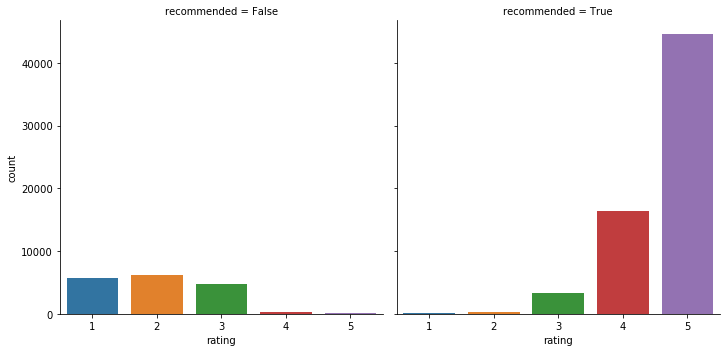

In [112]:
sns.catplot(x = "rating", col = "recommended", data = reviews, kind = "count")

<a id = "conclusions"></a>

## Conclusions

- Average overall rating is
- Top 10 cities: New York, LA, Chicago, San Francisco, Boston, Houston, Seattle, San Diego, Toronto, Washington DC
- There are 217 distinct foundations from 63 different brands, with 14 products coming from Clinique.
- Foundation prices range from \\$18 (Sephora brand) to \\$120 (La Mer and Giorgio Armani), and have an average price of \\$44.71 and median price of \\$42.
- Average rating increases with age


- Ratings decrease with higher Sephora tiers


- Incentivized ratings are higher than non-incentivized ratings on average (not surprising)


# HI KELLY I AM NOT DONE :)
